In [41]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA  # Updated import
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [56]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    # Go through dates
    for date, r in tqdm(returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        # If currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt *= (1 + ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s' % sell_price)
                print('Predicted Return: %s' % round(pred, 4))
                print('Actual Return: %s' % round(ret, 4))
                print('=======================================')
            continue

        # Get data till just before the current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                # Fit model
                model = ARIMA(curr_data, order=order).fit()

                # Get forecast
                pred = model.forecast()[0]
            except:
                pred = thresh - 1

        # If you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
           ((type(order) == float and np.random.random() < order) or 
            (type(order) == tuple and pred > thresh) or 
            (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s' % buy_price)
                
    if verbose:
        print('Total Amount: $%s' % round(amt, 2))
        
    # Graph
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min() * .95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * .5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx - 1][1], color=color, alpha=0.1)

        tot_return = round(100 * (amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s" % (thresh, round(amt, 2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Read Data

In [57]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)

In [58]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

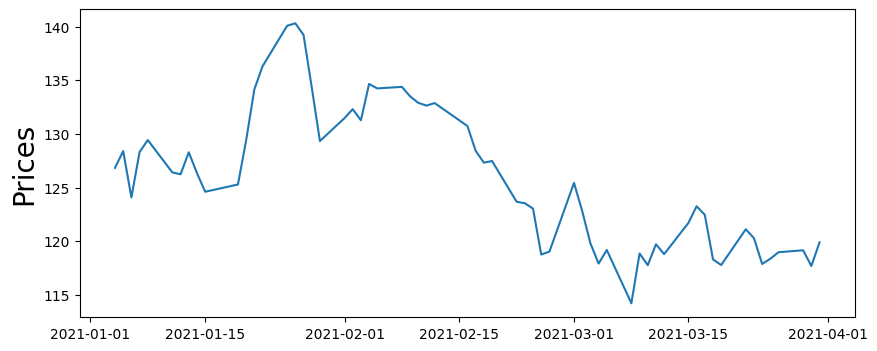

In [59]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

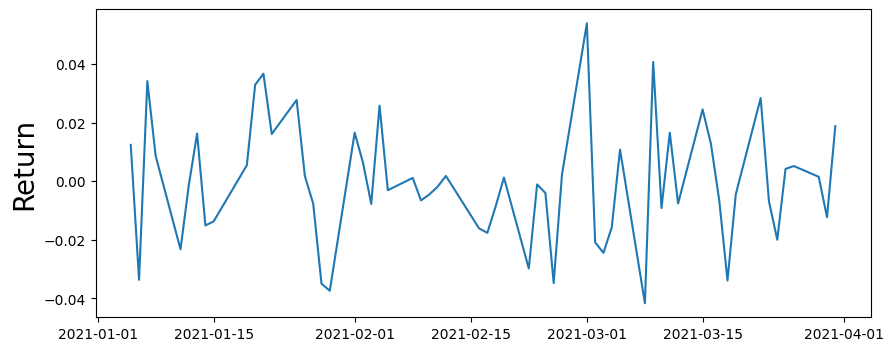

In [60]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

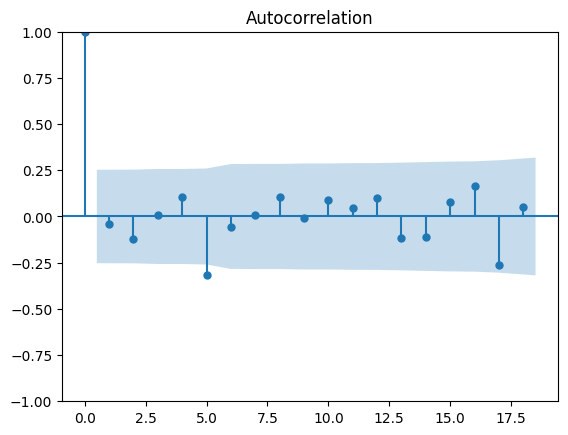

In [61]:
plot_acf(returns)
plt.show()

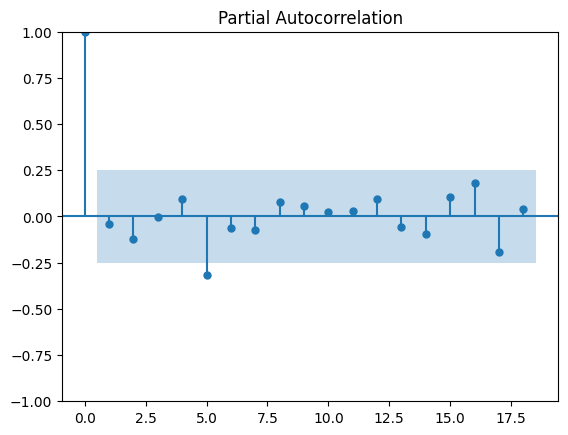

In [62]:
plot_pacf(returns)
plt.show()

# Baseline Model : Random Buying 

100%|██████████| 46/46 [00:00<00:00, 15231.55it/s]


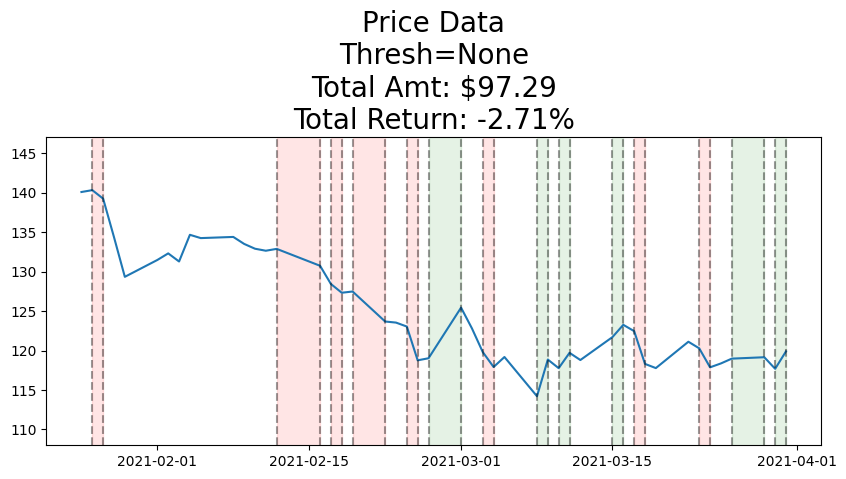

np.float64(97.28734556773249)

In [64]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [65]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=True, plot=False) for _ in range(1000)]

 15%|█▌        | 7/46 [00:00<00:00, 6949.14it/s]

Bought at $131.26974487304688
Sold at $134.65098571777344


UnboundLocalError: local variable 'pred' referenced before assignment

/tmp/ipykernel_76117/2783033276.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts)


Text(0.5, 1.0, 'Avg: $95.11\nSD: $6.32')

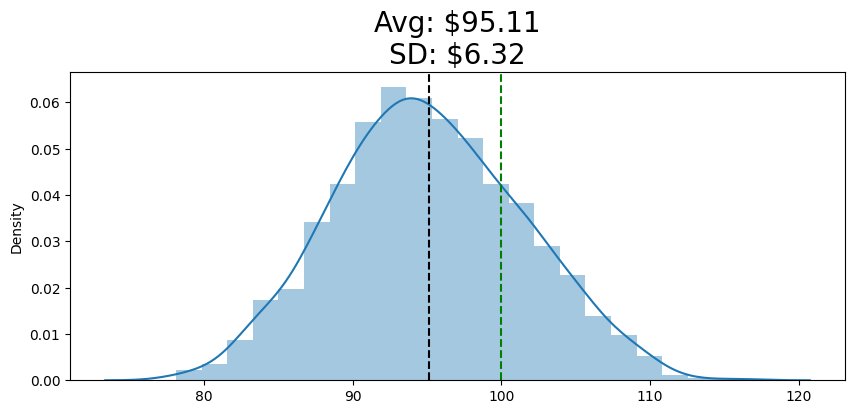

In [66]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If Last Return was Positive, Buy

  0%|          | 0/46 [00:00<?, ?it/s]/tmp/ipykernel_76117/1200582685.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (order == 'last' and curr_data[-1] > 0)):
100%|██████████| 46/46 [00:00<00:00, 11899.47it/s]


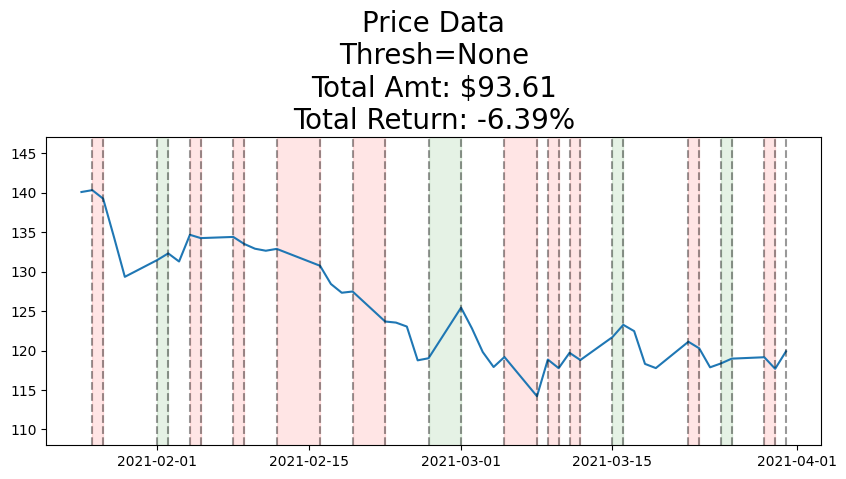

np.float64(93.60991730310306)

In [67]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

Running simulation with threshold: 0


  0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  2%|▏         | 3/186 [00:00<00:06, 27.45it/s]

Bought at $98.82
Sold at $97.93
Predicted Return: 0.0006
Actual Return: -0.009


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  4%|▍         | 7/186 [00:00<00:05, 34.48it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning:

Bought at $97.96
Sold at $97.74
Predicted Return: 0.002
Actual Return: -0.0022


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  8%|▊         | 15/186 [00:00<00:04, 34.49it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning

Bought at $92.47
Sold at $92.44
Predicted Return: 0.0003
Actual Return: -0.0003
Bought at $93.88
Sold at $91.42
Predicted Return: 0.0005
Actual Return: -0.0262


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions 

Bought at $88.26
Sold at $88.43
Predicted Return: 0.0004
Actual Return: 0.0019
Bought at $88.25
Sold at $87.08
Predicted Return: 0.0002
Actual Return: -0.0133


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions 

Bought at $88.54
Sold at $89.12
Predicted Return: 0.0002
Actual Return: 0.0066
Bought at $88.25
Sold at $88.95
Predicted Return: 0.0001
Actual Return: 0.0079
Bought at $89.24
Sold at $90.1
Predicted Return: 0.0001
Actual Return: 0.0096


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 84%|████████▍ | 156/186 [00:04<00:00, 30.94it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarnin

Bought at $92.02
Sold at $91.2
Predicted Return: 0.0001
Actual Return: -0.0089
Bought at $90.45
Sold at $90.38
Predicted Return: 0.0
Actual Return: -0.0008


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 89%|████████▊ | 165/186 [00:05<00:00, 30.48it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarnin

Bought at $95.09
Sold at $94.08
Predicted Return: 0.0003
Actual Return: -0.0106


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 95%|█████████▍| 176/186 [00:05<00:00, 27.55it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarnin

Bought at $94.56
Sold at $93.13
Predicted Return: 0.0002
Actual Return: -0.0151


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 98%|█████████▊| 183/186 [00:05<00:00, 24.53it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarnin

Bought at $92.54
Sold at $92.7
Predicted Return: 0.0002
Actual Return: 0.0017
Bought at $92.24
Sold at $92.38
Predicted Return: 0.0001
Actual Return: 0.0015


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
100%|██████████| 186/186 [00:06<00:00, 30.68it/s]


Bought at $91.38
Total Amount: $94.37


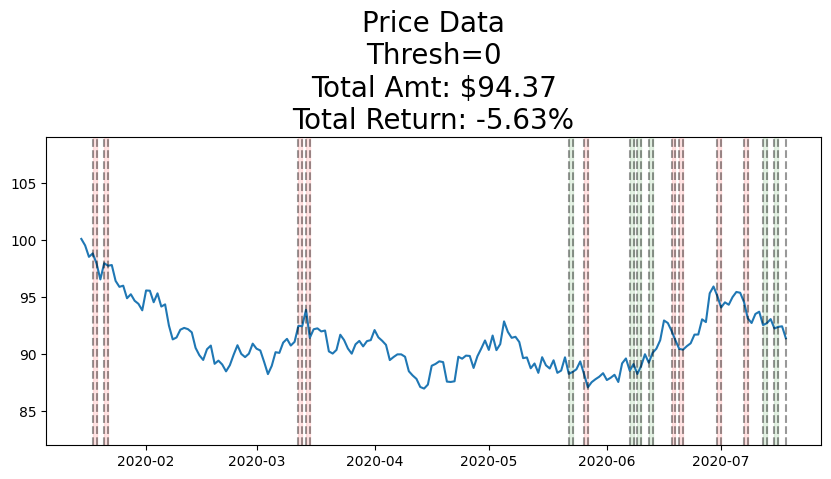

Running simulation with threshold: 0.001


  0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  1%|          | 2/186 [00:00<00:12, 14.76it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel

Bought at $97.96
Sold at $97.74
Predicted Return: 0.002
Actual Return: -0.0022


/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  7%|▋         | 13/186 [00:00<00:09, 18.05it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  8%|▊         | 15/186 [00:00<00:10, 16.87it/s]/tmp

Total Amount: $99.78


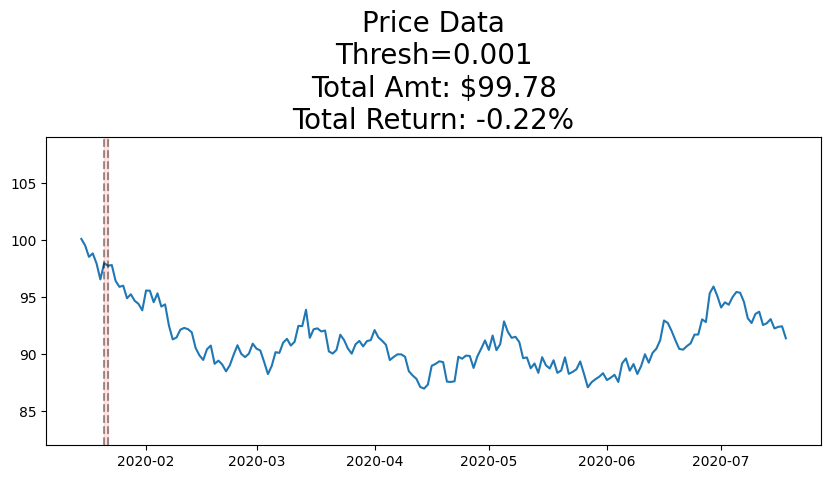

Running simulation with threshold: 0.005


  0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  1%|          | 2/186 [00:00<00:13, 13.23it/s]/tmp/ipykernel_76117/1200582685.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel

Total Amount: $100


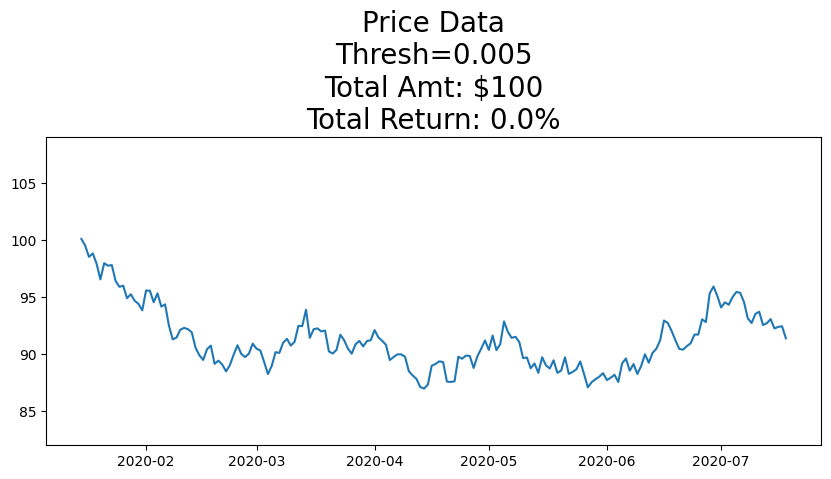

In [69]:
# Example usage:
# Generate synthetic data for testing
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=200, freq='D')
returns = pd.Series(np.random.randn(200) / 100, index=dates)
prices = (100 * (1 + returns).cumprod()).round(2)

# Test with various thresholds
for thresh in [0, 0.001, 0.005]:
    print(f"Running simulation with threshold: {thresh}")
    run_simulation(returns, prices, 100, (1, 0, 0), thresh, verbose=False)

# Try AR(1) Model

  0%|          | 0/46 [00:00<?, ?it/s]/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: 

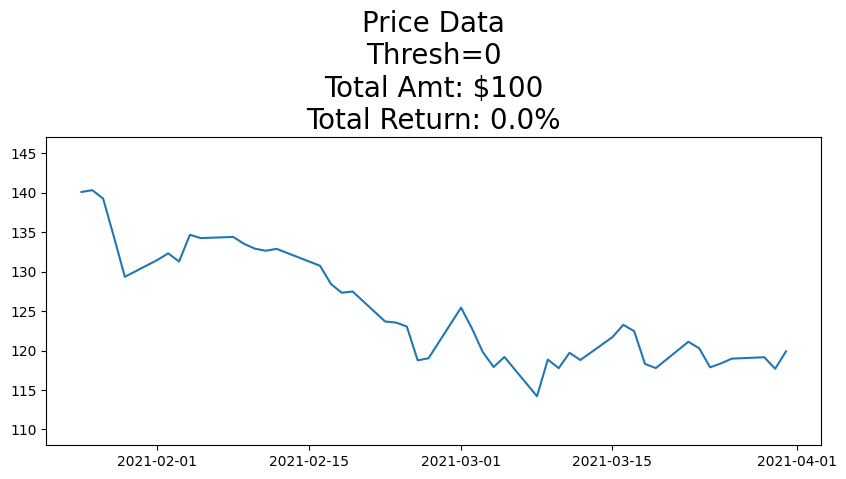

  0%|          | 0/46 [00:00<?, ?it/s]/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: 

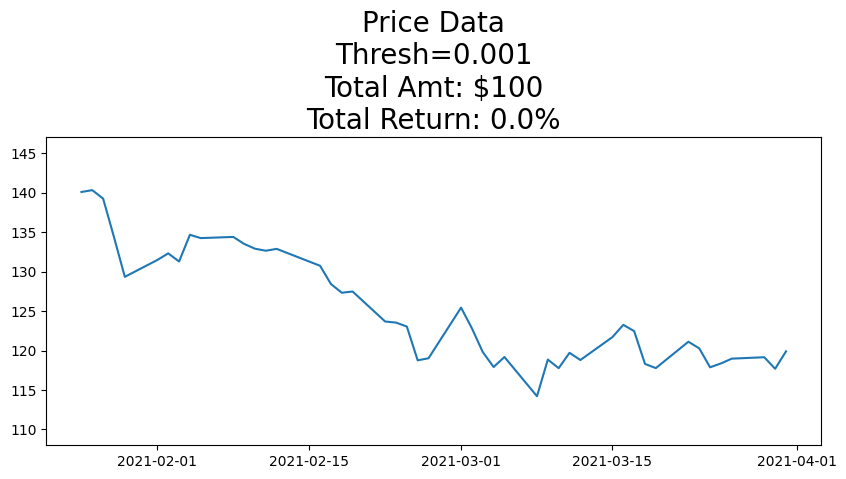

  0%|          | 0/46 [00:00<?, ?it/s]/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/haseeb/Documents/Dev/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: 

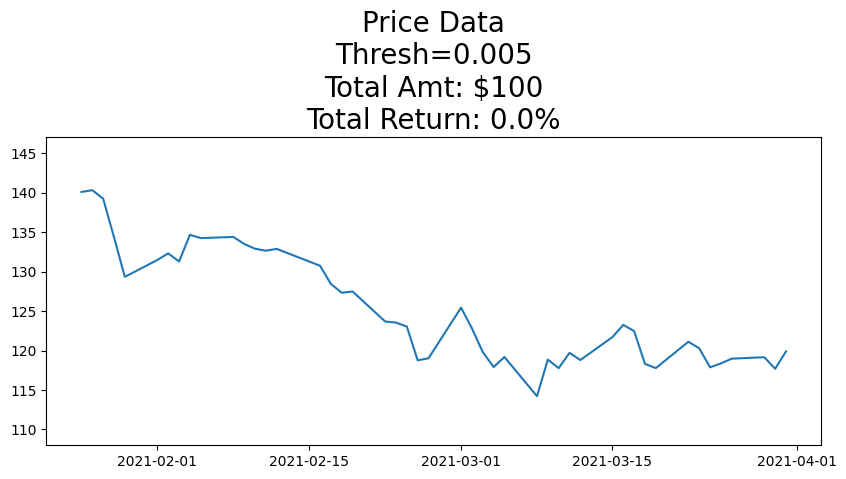

In [68]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

# Try AR(5) Model

100%|██████████| 46/46 [00:00<00:00, 11932.59it/s]


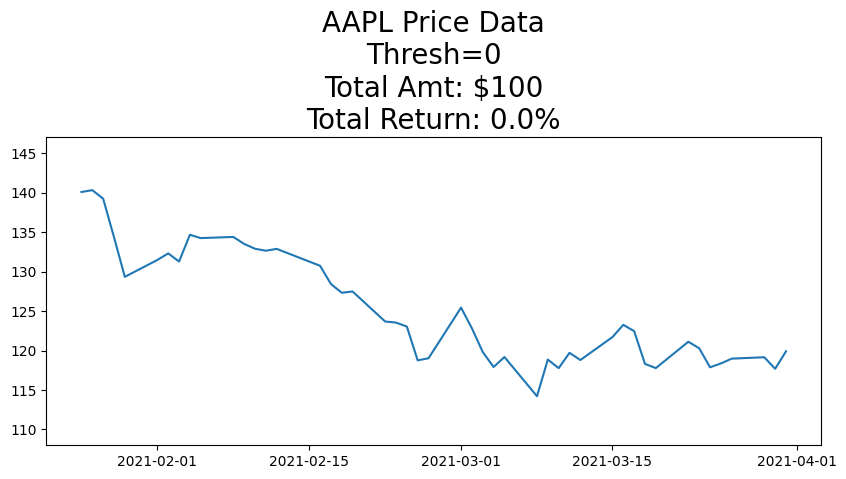

100%|██████████| 46/46 [00:00<00:00, 16649.81it/s]


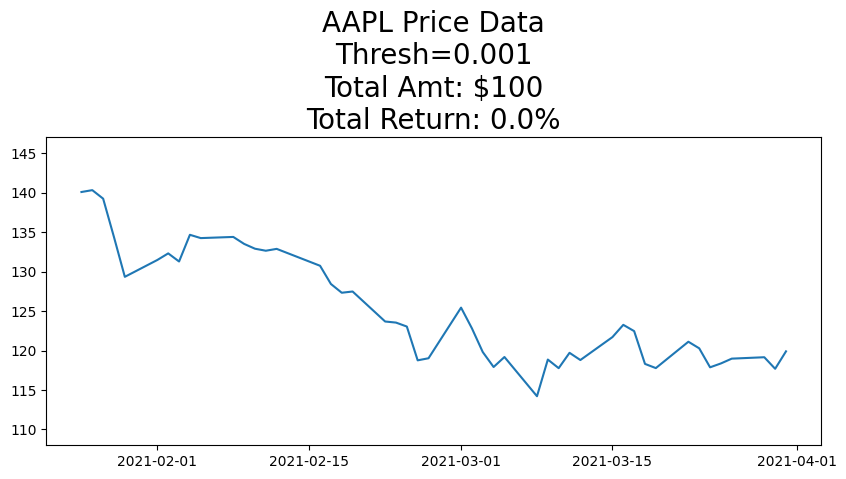

100%|██████████| 46/46 [00:00<00:00, 15787.41it/s]


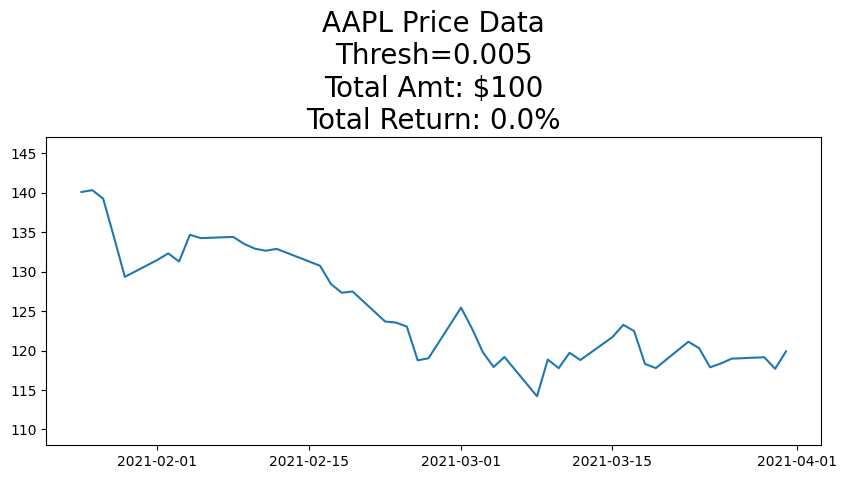

In [15]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

# Try ARMA(5,5) Model

100%|██████████| 46/46 [00:00<00:00, 6488.58it/s]


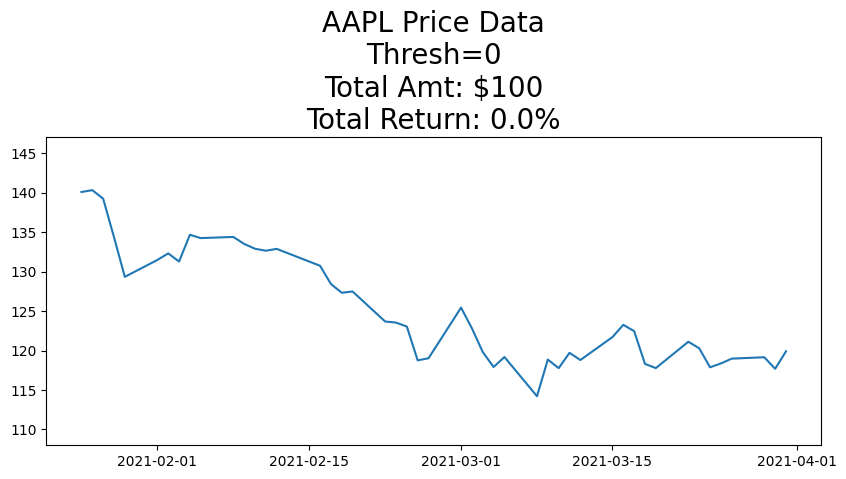

100%|██████████| 46/46 [00:00<00:00, 10741.45it/s]


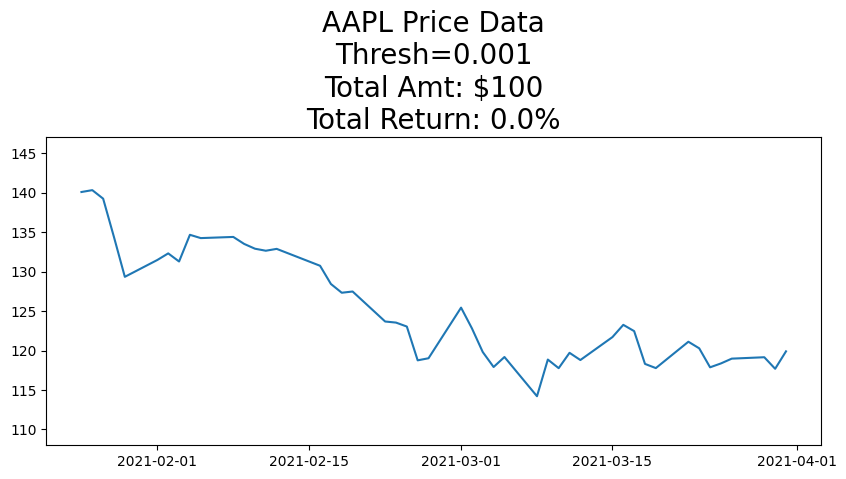

100%|██████████| 46/46 [00:00<00:00, 14050.25it/s]


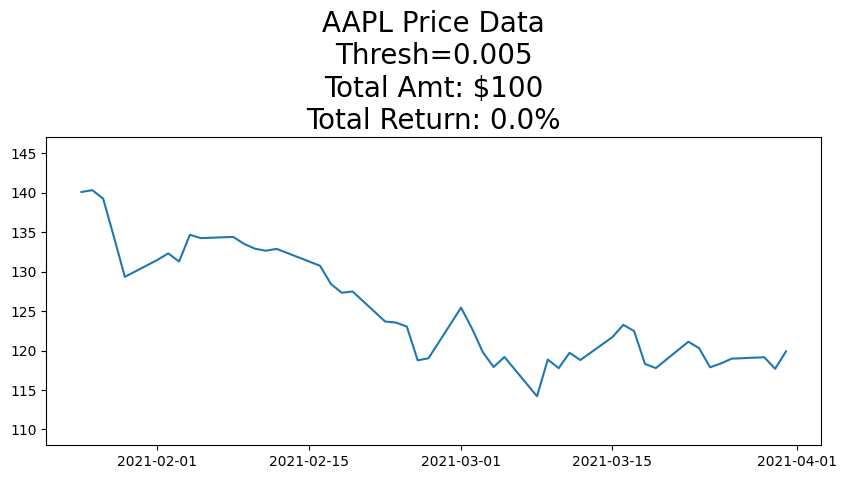

In [16]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)

100%|██████████| 23/23 [00:00<00:00, 207.33it/s]


Total Amount: $100


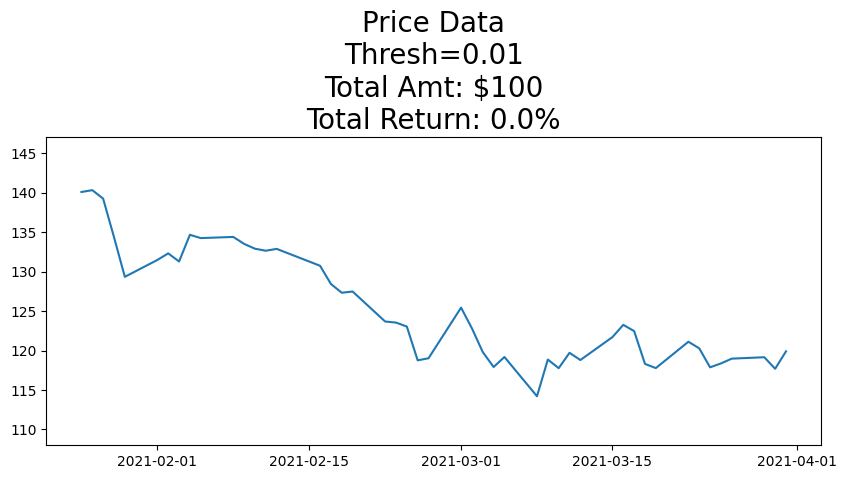

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def run_simulation_ml(returns, prices, amt, model, feature_window, thresh, verbose=False, plot=True):
    curr_holding = False
    events_list = []
    init_amt = amt

    # Prepare features
    features = np.array([returns.shift(i) for i in range(1, feature_window+1)]).T[feature_window:]
    labels = returns.values[feature_window:]
    dates = returns.index[feature_window:]

    # Train the model on initial data
    model.fit(features[:len(features)//2], labels[:len(labels)//2])

    for i, date in tqdm(enumerate(dates[len(dates)//2:]), total=len(dates)//2):
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt *= (1 + ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s' % sell_price)
                print('Predicted Return: %s' % round(pred, 4))
                print('Actual Return: %s' % round(ret, 4))
                print('=======================================')
            continue

        curr_data = features[len(dates)//2 + i].reshape(1, -1)
        pred = model.predict(curr_data)[0]

        if (not curr_holding) and pred > thresh:
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s' % buy_price)

    if verbose:
        print('Total Amount: $%s' % round(amt, 2))

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(prices[feature_window:])

        y_lims = (int(prices.min() * .95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * .5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx - 1][1], color=color, alpha=0.1)

        tot_return = round(100 * (amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s" % (thresh, round(amt, 2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt

# Example usage:
# Create a model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Run the simulation
final_amount = run_simulation_ml(returns, prices, amt=100, model=model, feature_window=14, thresh=0.01, verbose=True, plot=True)

Running simulation with threshold: 0


100%|██████████| 186/186 [00:00<00:00, 3156.34it/s]

ARIMA model fitting failed on 2020-01-15 00:00:00 with error: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.

Date: 2020-01-15 00:00:00, Prediction: -1, Threshold: 0
ARIMA model fitting failed on 2020-01-16 00:00:00 with error: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.

Date: 2020-01-16 00:00:00, Prediction: -1, Threshold: 0
ARIMA mode

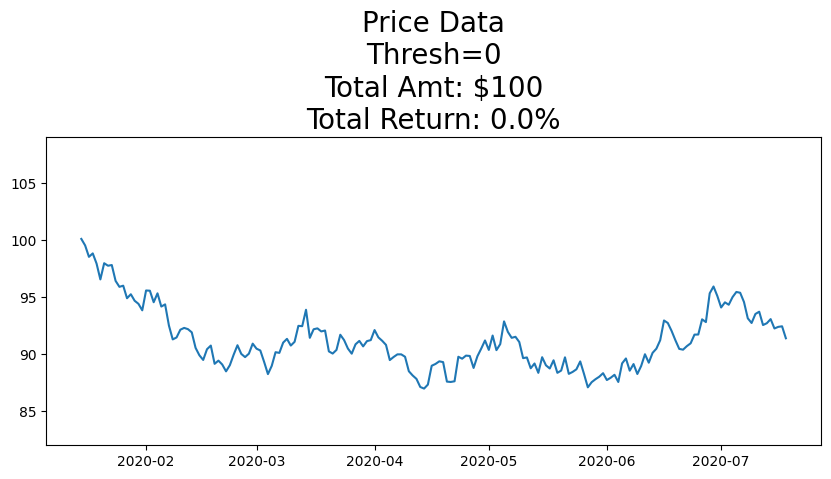

Running simulation with threshold: 0.001


100%|██████████| 186/186 [00:00<00:00, 4401.08it/s]

ARIMA model fitting failed on 2020-01-15 00:00:00 with error: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.

Date: 2020-01-15 00:00:00, Prediction: -0.999, Threshold: 0.001
ARIMA model fitting failed on 2020-01-16 00:00:00 with error: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.

Date: 2020-01-16 00:00:00, Prediction: -0.999, Threshold: 

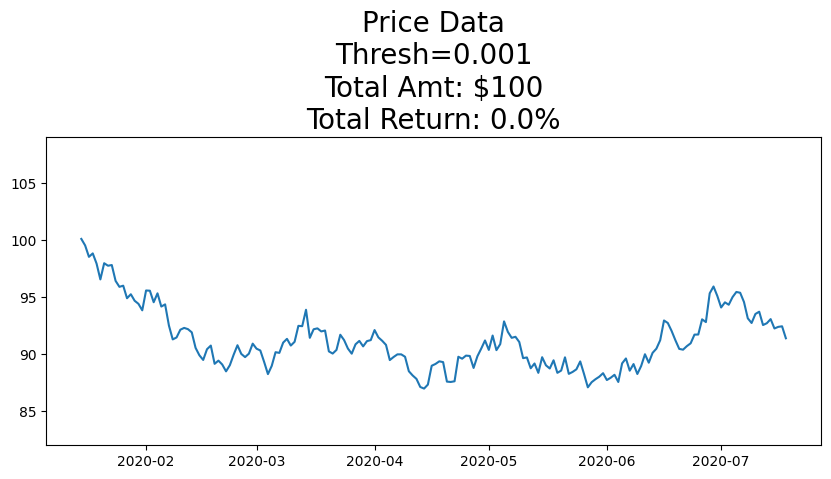

Running simulation with threshold: 0.005


100%|██████████| 186/186 [00:00<00:00, 4092.71it/s]

ARIMA model fitting failed on 2020-01-15 00:00:00 with error: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.

Date: 2020-01-15 00:00:00, Prediction: -0.995, Threshold: 0.005
ARIMA model fitting failed on 2020-01-16 00:00:00 with error: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.

Date: 2020-01-16 00:00:00, Prediction: -0.995, Threshold: 

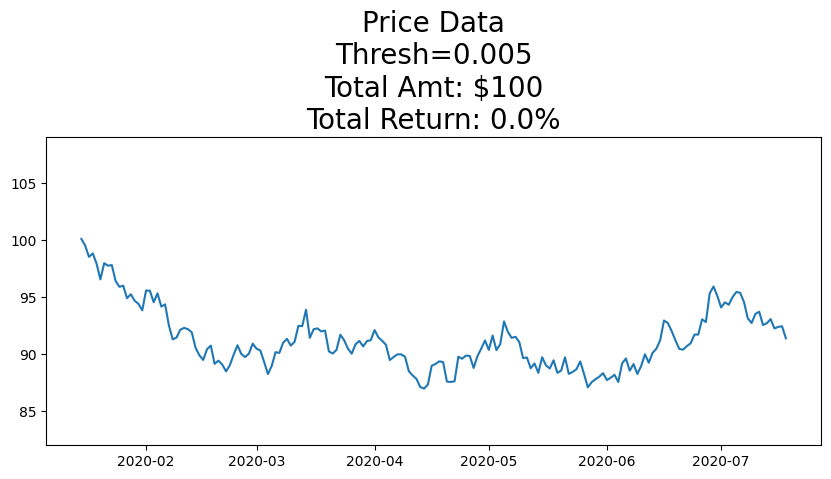

In [40]:
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Suppress specific warnings for cleaner output
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    # Go through dates
    for date, r in tqdm(returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        # If currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt *= (1 + ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s' % sell_price)
                print('Predicted Return: %s' % round(pred, 4))
                print('Actual Return: %s' % round(ret, 4))
                print('=======================================')
            continue

        # Get data till just before the current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                # Fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                # Get forecast
                pred = model.forecast()[0][0]
            except Exception as e:
                if verbose:
                    print(f"ARIMA model fitting failed on {date} with error: {e}")
                pred = thresh - 1

        # Debug statements to check predictions and threshold comparisons
        if verbose:
            print(f"Date: {date}, Prediction: {pred}, Threshold: {thresh}")

        # If you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
           ((type(order) == float and np.random.random() < order) or 
            (type(order) == tuple and pred > thresh) or 
            (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s' % buy_price)
                
    if verbose:
        print('Total Amount: $%s' % round(amt, 2))
        
    # Graph
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min() * .95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * .5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx - 1][1], color=color, alpha=0.1)

        tot_return = round(100 * (amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s" % (thresh, round(amt, 2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Generate synthetic data for testing
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=200, freq='D')
returns = pd.Series(np.random.randn(200) / 100, index=dates)
prices = (100 * (1 + returns).cumprod()).round(2)

# Test with various thresholds
for thresh in [0, 0.001, 0.005]:
    print(f"Running simulation with threshold: {thresh}")
    run_simulation(returns, prices, 100, (1, 0, 0), thresh, verbose=True)


Running simulation with threshold: 0


  0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  1%|          | 2/186 [00:00<00:09, 19.36it/s]

Date: 2020-01-15 00:00:00, Prediction: -0.005643440924136833, Threshold: 0
Date: 2020-01-16 00:00:00, Prediction: -0.001965692551051152, Threshold: 0
Date: 2020-01-17 00:00:00, Prediction: -0.003992932044688249, Threshold: 0
Date: 2020-01-18 00:00:00, Prediction: 0.0006274976156866732, Threshold: 0
Bought at $98.82
Sold at $97.93
Predicted Return: 0.0006
Actual Return: -0.009


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  3%|▎         | 6/186 [00:00<00:06, 27.42it/s]

Date: 2020-01-20 00:00:00, Prediction: -0.005846622207351524, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  5%|▍         | 9/186 [00:00<00:06, 26.04it/s]

Date: 2020-01-21 00:00:00, Prediction: 0.0020207970428389108, Threshold: 0
Bought at $97.96
Sold at $97.74
Predicted Return: 0.002
Actual Return: -0.0022
Date: 2020-01-23 00:00:00, Prediction: -0.0006400722887550573, Threshold: 0
Date: 2020-01-24 00:00:00, Prediction: -0.003250641550334633, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  6%|▋         | 12/186 [00:00<00:07, 23.80it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-01-25 00:00:00, Prediction: -0.0021716300328963527, Threshold: 0
Date: 2020-01-26 00:00:00, Prediction: -0.0011070774142201102, Threshold: 0
Date: 2020-01-27 00:00:00, Prediction: -0.0031515072946760683, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  8%|▊         | 15/186 [00:00<00:07, 23.45it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-01-28 00:00:00, Prediction: -0.0011082032259141065, Threshold: 0
Date: 2020-01-29 00:00:00, Prediction: -0.0022143234317192444, Threshold: 0
Date: 2020-01-30 00:00:00, Prediction: -0.0019580370711060366, Threshold: 0
Date: 2020-01-31 00:00:00, Prediction: -0.002379179993998654, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 10%|▉         | 18/186 [00:00<00:08, 20.58it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-02-01 00:00:00, Prediction: -0.00018515824344559348, Threshold: 0
Date: 2020-02-02 00:00:00, Prediction: -0.0012547878875899573, Threshold: 0
Date: 2020-02-03 00:00:00, Prediction: -0.00209227482869844, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 11%|█▏        | 21/186 [00:00<00:08, 18.91it/s]

Date: 2020-02-04 00:00:00, Prediction: -0.0011144872579800615, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 12%|█▏        | 23/186 [00:01<00:09, 16.36it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-05 00:00:00, Prediction: -0.0014750612839521775, Threshold: 0
Date: 2020-02-06 00:00:00, Prediction: -0.0016318150215047912, Threshold: 0
Date: 2020-02-07 00:00:00, Prediction: -0.0011383334839591532, Threshold: 0
Date: 2020-02-08 00:00:00, Prediction: -0.0024427954962587574, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 15%|█▍        | 27/186 [00:01<00:12, 13.04it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-09 00:00:00, Prediction: -0.0021893157839821924, Threshold: 0
Date: 2020-02-10 00:00:00, Prediction: -0.0018454126189904664, Threshold: 0
Date: 2020-02-11 00:00:00, Prediction: -0.0017908825897522715, Threshold: 0
Date: 2020-02-12 00:00:00, Prediction: -0.0018347457004870937, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 17%|█▋        | 31/186 [00:01<00:12, 12.87it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-02-13 00:00:00, Prediction: -0.001900597495517699, Threshold: 0
Date: 2020-02-14 00:00:00, Prediction: -0.0024771620487173563, Threshold: 0
Date: 2020-02-15 00:00:00, Prediction: -0.0024706798788023294, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 18%|█▊        | 33/186 [00:02<00:16,  9.50it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 19%|█▉        | 35/186 [00:02<00:14, 10.65it/s]/tmp

Date: 2020-02-16 00:00:00, Prediction: -0.0024193710605205703, Threshold: 0
Date: 2020-02-17 00:00:00, Prediction: -0.0015952704960502855, Threshold: 0
Date: 2020-02-18 00:00:00, Prediction: -0.0016554359470510325, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 20%|█▉        | 37/186 [00:02<00:13, 10.69it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-02-19 00:00:00, Prediction: -0.0027152760824341276, Threshold: 0
Date: 2020-02-20 00:00:00, Prediction: -0.002102865517384876, Threshold: 0
Date: 2020-02-21 00:00:00, Prediction: -0.002192048972965227, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 21%|██        | 39/186 [00:02<00:14, 10.08it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-02-22 00:00:00, Prediction: -0.0023036034563425484, Threshold: 0
Date: 2020-02-23 00:00:00, Prediction: -0.002119204937268943, Threshold: 0


 22%|██▏       | 41/186 [00:03<00:16,  8.65it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 23%|██▎       | 42/186 [00:03<00:16,  8.83it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-02-24 00:00:00, Prediction: -0.0016044571840951227, Threshold: 0
Date: 2020-02-25 00:00:00, Prediction: -0.0010962619586739734, Threshold: 0
Date: 2020-02-26 00:00:00, Prediction: -0.002036546379740876, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 24%|██▎       | 44/186 [00:03<00:14,  9.82it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 25%|██▍       | 46/186 [00:03<00:14,  9.49it/s]

Date: 2020-02-27 00:00:00, Prediction: -0.0018721149938359504, Threshold: 0
Date: 2020-02-28 00:00:00, Prediction: -0.0015587870933111683, Threshold: 0
Date: 2020-02-29 00:00:00, Prediction: -0.0010008172472100614, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 26%|██▌       | 48/186 [00:03<00:14,  9.83it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-01 00:00:00, Prediction: -0.0017246078627543842, Threshold: 0
Date: 2020-03-02 00:00:00, Prediction: -0.0016140680207919688, Threshold: 0
Date: 2020-03-03 00:00:00, Prediction: -0.0021208946874758153, Threshold: 0
Date: 2020-03-04 00:00:00, Prediction: -0.0024926060268416527, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 28%|██▊       | 52/186 [00:04<00:12, 10.57it/s]

Date: 2020-03-05 00:00:00, Prediction: -0.0013966041537559204, Threshold: 0
Date: 2020-03-06 00:00:00, Prediction: -0.0005245457770618287, Threshold: 0
Date: 2020-03-07 00:00:00, Prediction: -0.0014624238239595018, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 29%|██▉       | 54/186 [00:04<00:13, 10.03it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-08 00:00:00, Prediction: -0.0005732229665075981, Threshold: 0
Date: 2020-03-09 00:00:00, Prediction: -0.0008968064737961089, Threshold: 0
Date: 2020-03-10 00:00:00, Prediction: -0.001708119918788274, Threshold: 0


 30%|███       | 56/186 [00:04<00:13,  9.62it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 31%|███       | 58/186 [00:04<00:12, 10.61it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp

Date: 2020-03-11 00:00:00, Prediction: -0.0009537498359134041, Threshold: 0
Date: 2020-03-12 00:00:00, Prediction: 0.000290394818905929, Threshold: 0
Bought at $92.47
Sold at $92.44
Predicted Return: 0.0003
Actual Return: -0.0003
Date: 2020-03-14 00:00:00, Prediction: 0.0005326155262570234, Threshold: 0
Bought at $93.88
Sold at $91.42
Predicted Return: 0.0005
Actual Return: -0.0262
Date: 2020-03-16 00:00:00, Prediction: -0.0012765695123773506, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 34%|███▍      | 64/186 [00:05<00:10, 11.35it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-03-17 00:00:00, Prediction: -0.0010494690703878903, Threshold: 0
Date: 2020-03-18 00:00:00, Prediction: -0.0009827172618310375, Threshold: 0
Date: 2020-03-19 00:00:00, Prediction: -0.0010535737761750517, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 35%|███▌      | 66/186 [00:05<00:11, 10.50it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-03-20 00:00:00, Prediction: -0.0006769995615067032, Threshold: 0
Date: 2020-03-21 00:00:00, Prediction: -0.001228701260715784, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 37%|███▋      | 68/186 [00:05<00:12,  9.63it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 38%|███▊      | 70/186 [00:05<00:11,  9.70it/s]

Date: 2020-03-22 00:00:00, Prediction: -0.0013233335898527325, Threshold: 0
Date: 2020-03-23 00:00:00, Prediction: -0.0012573580363707763, Threshold: 0
Date: 2020-03-24 00:00:00, Prediction: -0.0009507663073032596, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 39%|███▊      | 72/186 [00:06<00:13,  8.56it/s]

Date: 2020-03-25 00:00:00, Prediction: -0.0009911811973092998, Threshold: 0
Date: 2020-03-26 00:00:00, Prediction: -0.0011145974982011732, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 40%|███▉      | 74/186 [00:06<00:12,  9.14it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-27 00:00:00, Prediction: -0.0012867568443987612, Threshold: 0
Date: 2020-03-28 00:00:00, Prediction: -0.0010801103276238597, Threshold: 0
Date: 2020-03-29 00:00:00, Prediction: -0.0009820307599602749, Threshold: 0
Date: 2020-03-30 00:00:00, Prediction: -0.0011237917926323537, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 42%|████▏     | 78/186 [00:06<00:11,  9.15it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-31 00:00:00, Prediction: -0.001008326714884471, Threshold: 0
Date: 2020-04-01 00:00:00, Prediction: -0.0010351791010050362, Threshold: 0
Date: 2020-04-02 00:00:00, Prediction: -0.0007658735073684469, Threshold: 0
Date: 2020-04-03 00:00:00, Prediction: -0.0008907719299051893, Threshold: 0
Date: 2020-04-04 00:00:00, Prediction: -0.0009103309445203567, Threshold: 0
Date: 2020-04-05 00:00:00, Prediction: -0.0008823062637954061, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 45%|████▌     | 84/186 [00:07<00:09, 10.34it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-04-06 00:00:00, Prediction: -0.0011733313812044386, Threshold: 0
Date: 2020-04-07 00:00:00, Prediction: -0.0011194129796588273, Threshold: 0
Date: 2020-04-08 00:00:00, Prediction: -0.0010513597496229093, Threshold: 0
Date: 2020-04-09 00:00:00, Prediction: -0.00101323455361033, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 47%|████▋     | 88/186 [00:07<00:09, 10.76it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-04-10 00:00:00, Prediction: -0.0009180097328668284, Threshold: 0
Date: 2020-04-11 00:00:00, Prediction: -0.0011590448533337417, Threshold: 0
Date: 2020-04-12 00:00:00, Prediction: -0.0011940389888407238, Threshold: 0
Date: 2020-04-13 00:00:00, Prediction: -0.0012075588549228533, Threshold: 0
Date: 2020-04-14 00:00:00, Prediction: -0.0012869808995596992, Threshold: 0
Date: 2020-04-15 00:00:00, Prediction: -0.0013026261681503338, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 51%|█████     | 94/186 [00:08<00:08, 10.50it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-04-16 00:00:00, Prediction: -0.0010320178470566404, Threshold: 0
Date: 2020-04-17 00:00:00, Prediction: -0.0010071153056532547, Threshold: 0
Date: 2020-04-18 00:00:00, Prediction: -0.000964020319718735, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 52%|█████▏    | 96/186 [00:08<00:09,  9.74it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 52%|█████▏    | 97/186 [00:08<00:09,  9.75it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp

Date: 2020-04-19 00:00:00, Prediction: -0.0009902261217251932, Threshold: 0
Date: 2020-04-20 00:00:00, Prediction: -0.0012995602457755854, Threshold: 0
Date: 2020-04-21 00:00:00, Prediction: -0.001141885977374946, Threshold: 0
Date: 2020-04-22 00:00:00, Prediction: -0.0011210129187037986, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 54%|█████▍    | 101/186 [00:08<00:09,  9.06it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 55%|█████▍    | 102/186 [00:09<00:09,  8.79it/s]

Date: 2020-04-23 00:00:00, Prediction: -0.0006201274676570967, Threshold: 0
Date: 2020-04-24 00:00:00, Prediction: -0.0009223938939935765, Threshold: 0
Date: 2020-04-25 00:00:00, Prediction: -0.0008519266988740897, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 55%|█████▌    | 103/186 [00:09<00:09,  8.44it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 56%|█████▌    | 104/186 [00:09<00:09,  8.75it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-04-26 00:00:00, Prediction: -0.0008721418742128508, Threshold: 0
Date: 2020-04-27 00:00:00, Prediction: -0.0010422962021687495, Threshold: 0


 56%|█████▋    | 105/186 [00:09<00:09,  8.70it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 57%|█████▋    | 106/186 [00:09<00:09,  8.72it/s]

Date: 2020-04-28 00:00:00, Prediction: -0.0009433295160791263, Threshold: 0
Date: 2020-04-29 00:00:00, Prediction: -0.0007614543479833773, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 58%|█████▊    | 107/186 [00:09<00:09,  8.67it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 59%|█████▊    | 109/186 [00:09<00:08,  8.58it/s]

Date: 2020-04-30 00:00:00, Prediction: -0.0006264972287964918, Threshold: 0
Date: 2020-05-01 00:00:00, Prediction: -0.0008226194831978128, Threshold: 0
Date: 2020-05-02 00:00:00, Prediction: -0.0007889302982215055, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 60%|█████▉    | 111/186 [00:10<00:07,  9.58it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 60%|██████    | 112/186 [00:10<00:08,  8.96it/s]/t

Date: 2020-05-03 00:00:00, Prediction: -0.0004262078522533011, Threshold: 0
Date: 2020-05-04 00:00:00, Prediction: -0.0009524773254631703, Threshold: 0
Date: 2020-05-05 00:00:00, Prediction: -0.0010002890022333024, Threshold: 0
Date: 2020-05-06 00:00:00, Prediction: -0.0002662455960054274, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 61%|██████▏   | 114/186 [00:10<00:07,  9.77it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 62%|██████▏   | 115/186 [00:10<00:07,  9.75it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-07 00:00:00, Prediction: -0.0004906869918197572, Threshold: 0
Date: 2020-05-08 00:00:00, Prediction: -0.0007027701871729117, Threshold: 0
Date: 2020-05-09 00:00:00, Prediction: -0.0005279241301823866, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 63%|██████▎   | 117/186 [00:10<00:06, 10.00it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 63%|██████▎   | 118/186 [00:10<00:07,  8.68it/s]

Date: 2020-05-10 00:00:00, Prediction: -0.0003625709122327818, Threshold: 0
Date: 2020-05-11 00:00:00, Prediction: -0.0008269688685278604, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 65%|██████▍   | 120/186 [00:11<00:07,  9.19it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 65%|██████▌   | 121/186 [00:11<00:07,  8.83it/s]

Date: 2020-05-12 00:00:00, Prediction: -0.0005448923928095095, Threshold: 0
Date: 2020-05-13 00:00:00, Prediction: -0.0010157775185287926, Threshold: 0
Date: 2020-05-14 00:00:00, Prediction: -0.0005426839729812912, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 66%|██████▌   | 122/186 [00:11<00:08,  7.78it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 66%|██████▌   | 123/186 [00:11<00:08,  7.56it/s]

Date: 2020-05-15 00:00:00, Prediction: -0.0015966960121046162, Threshold: 0
Date: 2020-05-16 00:00:00, Prediction: -0.00038798309539565844, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 67%|██████▋   | 124/186 [00:11<00:08,  6.98it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 67%|██████▋   | 125/186 [00:11<00:08,  7.38it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-17 00:00:00, Prediction: -0.0006865117502280594, Threshold: 0
Date: 2020-05-18 00:00:00, Prediction: -0.0012945348216645536, Threshold: 0
Date: 2020-05-19 00:00:00, Prediction: -6.451533438400292e-05, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 68%|██████▊   | 127/186 [00:12<00:06,  8.71it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 69%|██████▉   | 128/186 [00:12<00:07,  7.58it/s]

Date: 2020-05-20 00:00:00, Prediction: -0.001039649279151938, Threshold: 0
Date: 2020-05-21 00:00:00, Prediction: -0.0016430389832341324, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 69%|██████▉   | 129/186 [00:12<00:07,  7.99it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 70%|███████   | 131/186 [00:12<00:05, 10.39it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-22 00:00:00, Prediction: 0.0004260004630847618, Threshold: 0
Bought at $88.26
Sold at $88.43
Predicted Return: 0.0004
Actual Return: 0.0019
Date: 2020-05-24 00:00:00, Prediction: -0.0010728654886871412, Threshold: 0
Date: 2020-05-25 00:00:00, Prediction: -0.0014241610951726594, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 72%|███████▏  | 133/186 [00:12<00:05, 10.05it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 73%|███████▎  | 135/186 [00:12<00:04, 12.04it/s]

Date: 2020-05-26 00:00:00, Prediction: 0.00021127700106176434, Threshold: 0
Bought at $88.25
Sold at $87.08
Predicted Return: 0.0002
Actual Return: -0.0133
Date: 2020-05-28 00:00:00, Prediction: -0.001346910606208976, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 74%|███████▎  | 137/186 [00:12<00:04, 10.17it/s]

Date: 2020-05-29 00:00:00, Prediction: -0.0011284699132363563, Threshold: 0
Date: 2020-05-30 00:00:00, Prediction: -0.0010644458394858435, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 75%|███████▍  | 139/186 [00:13<00:05,  9.10it/s]

Date: 2020-05-31 00:00:00, Prediction: -0.001104097839766902, Threshold: 0
Date: 2020-06-01 00:00:00, Prediction: -0.00034442168299476494, Threshold: 0
Date: 2020-06-02 00:00:00, Prediction: -0.001046222358216555, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 76%|███████▌  | 141/186 [00:13<00:05,  8.27it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 76%|███████▋  | 142/186 [00:13<00:05,  7.41it/s]

Date: 2020-06-03 00:00:00, Prediction: -0.001065128259561467, Threshold: 0
Date: 2020-06-04 00:00:00, Prediction: -0.00030117073342734654, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 77%|███████▋  | 144/186 [00:13<00:04,  8.64it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 78%|███████▊  | 145/186 [00:14<00:04,  8.70it/s]

Date: 2020-06-05 00:00:00, Prediction: -0.0024299828907193674, Threshold: 0
Date: 2020-06-06 00:00:00, Prediction: -0.001088007313677414, Threshold: 0
Date: 2020-06-07 00:00:00, Prediction: 0.00021380412925859022, Threshold: 0
Bought at $88.54
Sold at $89.12
Predicted Return: 0.0002
Actual Return: 0.0066


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 79%|███████▉  | 147/186 [00:14<00:03, 10.79it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 80%|████████  | 149/186 [00:14<00:03, 11.11it/s]

Date: 2020-06-09 00:00:00, Prediction: 0.00010577251915591733, Threshold: 0
Bought at $88.25
Sold at $88.95
Predicted Return: 0.0001
Actual Return: 0.0079
Date: 2020-06-11 00:00:00, Prediction: -0.0017117777267645464, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 81%|████████  | 151/186 [00:14<00:02, 12.42it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-12 00:00:00, Prediction: 7.081454171321518e-05, Threshold: 0
Bought at $89.24
Sold at $90.1
Predicted Return: 0.0001
Actual Return: 0.0096
Date: 2020-06-14 00:00:00, Prediction: -0.001019240802372423, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 82%|████████▏ | 153/186 [00:14<00:03,  9.54it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 83%|████████▎ | 155/186 [00:14<00:03,  9.59it/s]

Date: 2020-06-15 00:00:00, Prediction: -0.0013321951295052268, Threshold: 0
Date: 2020-06-16 00:00:00, Prediction: -0.0019764202472690776, Threshold: 0
Date: 2020-06-17 00:00:00, Prediction: -0.00023884794457495966, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 84%|████████▍ | 157/186 [00:15<00:02, 11.10it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 85%|████████▌ | 159/186 [00:15<00:02, 12.60it/s]

Date: 2020-06-18 00:00:00, Prediction: 0.00012706633568463862, Threshold: 0
Bought at $92.02
Sold at $91.2
Predicted Return: 0.0001
Actual Return: -0.0089
Date: 2020-06-20 00:00:00, Prediction: 8.079535627675055e-06, Threshold: 0
Bought at $90.45
Sold at $90.38
Predicted Return: 0.0
Actual Return: -0.0008


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 87%|████████▋ | 161/186 [00:15<00:02, 10.86it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-22 00:00:00, Prediction: -0.0008046179549621819, Threshold: 0
Date: 2020-06-23 00:00:00, Prediction: -0.0007353562613223813, Threshold: 0
Date: 2020-06-24 00:00:00, Prediction: -0.0010559698941601985, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 88%|████████▊ | 163/186 [00:15<00:02, 10.27it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-25 00:00:00, Prediction: -0.0004893325024986054, Threshold: 0
Date: 2020-06-26 00:00:00, Prediction: -0.0013762643603723649, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 89%|████████▊ | 165/186 [00:15<00:02,  8.93it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-27 00:00:00, Prediction: -0.0002215653402980336, Threshold: 0
Date: 2020-06-28 00:00:00, Prediction: -0.0022303934151702703, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 90%|████████▉ | 167/186 [00:16<00:02,  7.42it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 90%|█████████ | 168/186 [00:16<00:02,  7.30it/s]

Date: 2020-06-29 00:00:00, Prediction: -0.0005668302556579659, Threshold: 0
Date: 2020-06-30 00:00:00, Prediction: 0.00028013342484439226, Threshold: 0
Bought at $95.09
Sold at $94.08
Predicted Return: 0.0003
Actual Return: -0.0106


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 92%|█████████▏| 171/186 [00:16<00:01,  8.91it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 92%|█████████▏| 172/186 [00:16<00:01,  8.05it/s]

Date: 2020-07-02 00:00:00, Prediction: -0.0005651809747005295, Threshold: 0
Date: 2020-07-03 00:00:00, Prediction: -0.0001584565386474197, Threshold: 0
Date: 2020-07-04 00:00:00, Prediction: -0.0006840076995495619, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 93%|█████████▎| 173/186 [00:16<00:01,  8.05it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 94%|█████████▎| 174/186 [00:17<00:01,  7.19it/s]

Date: 2020-07-05 00:00:00, Prediction: -0.0004954455186272982, Threshold: 0
Date: 2020-07-06 00:00:00, Prediction: -0.000181526902488753, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 94%|█████████▍| 175/186 [00:17<00:01,  7.49it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 95%|█████████▌| 177/186 [00:17<00:01,  8.48it/s]

Date: 2020-07-07 00:00:00, Prediction: 0.0002196111320281737, Threshold: 0
Bought at $94.56
Sold at $93.13
Predicted Return: 0.0002
Actual Return: -0.0151
Date: 2020-07-09 00:00:00, Prediction: -0.00016649525635641126, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 96%|█████████▌| 178/186 [00:17<00:01,  7.86it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 96%|█████████▌| 179/186 [00:17<00:00,  7.47it/s]

Date: 2020-07-10 00:00:00, Prediction: -0.0007346350830047412, Threshold: 0
Date: 2020-07-11 00:00:00, Prediction: -0.000409296898987479, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 97%|█████████▋| 180/186 [00:17<00:00,  7.70it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 98%|█████████▊| 182/186 [00:18<00:00,  9.92it/s]

Date: 2020-07-12 00:00:00, Prediction: 0.00022499073081747517, Threshold: 0
Bought at $92.54
Sold at $92.7
Predicted Return: 0.0002
Actual Return: 0.0017
Date: 2020-07-14 00:00:00, Prediction: -0.0005328003002970645, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 99%|█████████▉| 184/186 [00:18<00:00, 11.69it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-07-15 00:00:00, Prediction: 6.068394842526808e-05, Threshold: 0
Bought at $92.24
Sold at $92.38
Predicted Return: 0.0001
Actual Return: 0.0015
Date: 2020-07-17 00:00:00, Prediction: -0.0004058317712355589, Threshold: 0


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
100%|██████████| 186/186 [00:18<00:00, 10.09it/s]


Date: 2020-07-18 00:00:00, Prediction: 0.00016277956830599113, Threshold: 0
Bought at $91.38
Total Amount: $94.37


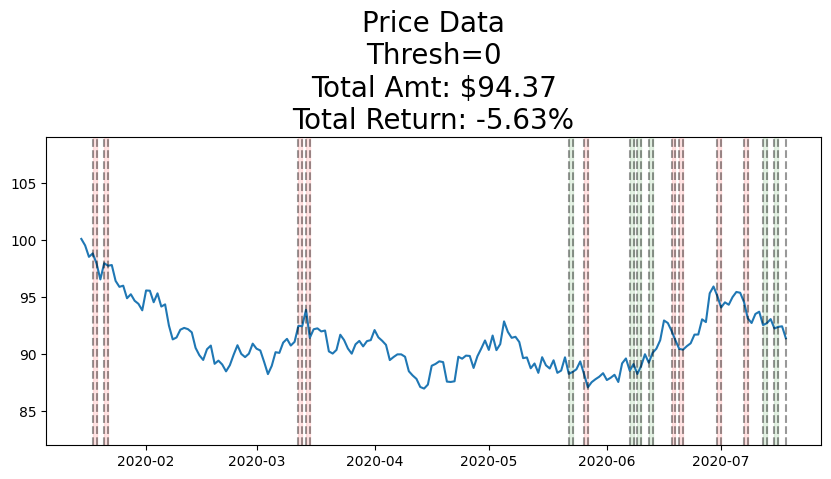

Running simulation with threshold: 0.001


  0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  1%|          | 1/186 [00:00<00:22,  8.31it/s]

Date: 2020-01-15 00:00:00, Prediction: -0.005643440924136833, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  1%|          | 2/186 [00:00<00:23,  7.83it/s]

Date: 2020-01-16 00:00:00, Prediction: -0.001965692551051152, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  2%|▏         | 3/186 [00:00<00:23,  7.71it/s]

Date: 2020-01-17 00:00:00, Prediction: -0.003992932044688249, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  2%|▏         | 4/186 [00:00<00:26,  6.93it/s]

Date: 2020-01-18 00:00:00, Prediction: 0.0006274976156866732, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  3%|▎         | 5/186 [00:00<00:25,  7.23it/s]

Date: 2020-01-19 00:00:00, Prediction: -0.0032321344949746648, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  3%|▎         | 6/186 [00:00<00:23,  7.64it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-01-20 00:00:00, Prediction: -0.005846622207351524, Threshold: 0.001


  4%|▍         | 7/186 [00:00<00:22,  7.95it/s]

Date: 2020-01-21 00:00:00, Prediction: 0.0020207970428389108, Threshold: 0.001
Bought at $97.96
Sold at $97.74
Predicted Return: 0.002
Actual Return: -0.0022


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  5%|▍         | 9/186 [00:01<00:16, 10.61it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-01-23 00:00:00, Prediction: -0.0006400722887550573, Threshold: 0.001
Date: 2020-01-24 00:00:00, Prediction: -0.003250641550334633, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  6%|▌         | 11/186 [00:01<00:15, 11.11it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  7%|▋         | 13/186 [00:01<00:14, 11.75it/s]/tmp

Date: 2020-01-25 00:00:00, Prediction: -0.0021716300328963527, Threshold: 0.001
Date: 2020-01-26 00:00:00, Prediction: -0.0011070774142201102, Threshold: 0.001
Date: 2020-01-27 00:00:00, Prediction: -0.0031515072946760683, Threshold: 0.001
Date: 2020-01-28 00:00:00, Prediction: -0.0011082032259141065, Threshold: 0.001
Date: 2020-01-29 00:00:00, Prediction: -0.0022143234317192444, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  9%|▉         | 17/186 [00:01<00:13, 12.90it/s]

Date: 2020-01-30 00:00:00, Prediction: -0.0019580370711060366, Threshold: 0.001
Date: 2020-01-31 00:00:00, Prediction: -0.002379179993998654, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 10%|█         | 19/186 [00:01<00:14, 11.49it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-01 00:00:00, Prediction: -0.00018515824344559348, Threshold: 0.001
Date: 2020-02-02 00:00:00, Prediction: -0.0012547878875899573, Threshold: 0.001
Date: 2020-02-03 00:00:00, Prediction: -0.00209227482869844, Threshold: 0.001
Date: 2020-02-04 00:00:00, Prediction: -0.0011144872579800615, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 12%|█▏        | 23/186 [00:02<00:15, 10.74it/s]

Date: 2020-02-05 00:00:00, Prediction: -0.0014750612839521775, Threshold: 0.001
Date: 2020-02-06 00:00:00, Prediction: -0.0016318150215047912, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 13%|█▎        | 25/186 [00:02<00:14, 11.27it/s]

Date: 2020-02-07 00:00:00, Prediction: -0.0011383334839591532, Threshold: 0.001
Date: 2020-02-08 00:00:00, Prediction: -0.0024427954962587574, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-02-09 00:00:00, Prediction: -0.0021893157839821924, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 15%|█▍        | 27/186 [00:02<00:14, 11.02it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 16%|█▌        | 29/186 [00:02<00:13, 11.57it/s]/tmp

Date: 2020-02-10 00:00:00, Prediction: -0.0018454126189904664, Threshold: 0.001
Date: 2020-02-11 00:00:00, Prediction: -0.0017908825897522715, Threshold: 0.001
Date: 2020-02-12 00:00:00, Prediction: -0.0018347457004870937, Threshold: 0.001
Date: 2020-02-13 00:00:00, Prediction: -0.001900597495517699, Threshold: 0.001
Date: 2020-02-14 00:00:00, Prediction: -0.0024771620487173563, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 18%|█▊        | 33/186 [00:03<00:12, 11.88it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-15 00:00:00, Prediction: -0.0024706798788023294, Threshold: 0.001
Date: 2020-02-16 00:00:00, Prediction: -0.0024193710605205703, Threshold: 0.001
Date: 2020-02-17 00:00:00, Prediction: -0.0015952704960502855, Threshold: 0.001
Date: 2020-02-18 00:00:00, Prediction: -0.0016554359470510325, Threshold: 0.001
Date: 2020-02-19 00:00:00, Prediction: -0.0027152760824341276, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 20%|█▉        | 37/186 [00:03<00:12, 12.31it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 21%|██        | 39/186 [00:03<00:12, 11.43it/s]

Date: 2020-02-20 00:00:00, Prediction: -0.002102865517384876, Threshold: 0.001
Date: 2020-02-21 00:00:00, Prediction: -0.002192048972965227, Threshold: 0.001
Date: 2020-02-22 00:00:00, Prediction: -0.0023036034563425484, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 22%|██▏       | 41/186 [00:03<00:13, 10.77it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-23 00:00:00, Prediction: -0.002119204937268943, Threshold: 0.001
Date: 2020-02-24 00:00:00, Prediction: -0.0016044571840951227, Threshold: 0.001
Date: 2020-02-25 00:00:00, Prediction: -0.0010962619586739734, Threshold: 0.001
Date: 2020-02-26 00:00:00, Prediction: -0.002036546379740876, Threshold: 0.001
Date: 2020-02-27 00:00:00, Prediction: -0.0018721149938359504, Threshold: 0.001
Date: 2020-02-28 00:00:00, Prediction: -0.0015587870933111683, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 25%|██▌       | 47/186 [00:04<00:11, 12.08it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-29 00:00:00, Prediction: -0.0010008172472100614, Threshold: 0.001
Date: 2020-03-01 00:00:00, Prediction: -0.0017246078627543842, Threshold: 0.001
Date: 2020-03-02 00:00:00, Prediction: -0.0016140680207919688, Threshold: 0.001
Date: 2020-03-03 00:00:00, Prediction: -0.0021208946874758153, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 27%|██▋       | 51/186 [00:04<00:10, 13.06it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-04 00:00:00, Prediction: -0.0024926060268416527, Threshold: 0.001
Date: 2020-03-05 00:00:00, Prediction: -0.0013966041537559204, Threshold: 0.001
Date: 2020-03-06 00:00:00, Prediction: -0.0005245457770618287, Threshold: 0.001
Date: 2020-03-07 00:00:00, Prediction: -0.0014624238239595018, Threshold: 0.001
Date: 2020-03-08 00:00:00, Prediction: -0.0005732229665075981, Threshold: 0.001
Date: 2020-03-09 00:00:00, Prediction: -0.0008968064737961089, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 31%|███       | 57/186 [00:04<00:09, 13.68it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-10 00:00:00, Prediction: -0.001708119918788274, Threshold: 0.001
Date: 2020-03-11 00:00:00, Prediction: -0.0009537498359134041, Threshold: 0.001
Date: 2020-03-12 00:00:00, Prediction: 0.000290394818905929, Threshold: 0.001
Date: 2020-03-13 00:00:00, Prediction: -0.0009823227951273627, Threshold: 0.001
Date: 2020-03-14 00:00:00, Prediction: 0.0005326155262570234, Threshold: 0.001
Date: 2020-03-15 00:00:00, Prediction: -0.0013709325072214387, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 34%|███▍      | 63/186 [00:05<00:10, 11.57it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-16 00:00:00, Prediction: -0.0012765695123773506, Threshold: 0.001
Date: 2020-03-17 00:00:00, Prediction: -0.0010494690703878903, Threshold: 0.001
Date: 2020-03-18 00:00:00, Prediction: -0.0009827172618310375, Threshold: 0.001
Date: 2020-03-19 00:00:00, Prediction: -0.0010535737761750517, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 36%|███▌      | 67/186 [00:05<00:10, 11.32it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-20 00:00:00, Prediction: -0.0006769995615067032, Threshold: 0.001
Date: 2020-03-21 00:00:00, Prediction: -0.001228701260715784, Threshold: 0.001
Date: 2020-03-22 00:00:00, Prediction: -0.0013233335898527325, Threshold: 0.001
Date: 2020-03-23 00:00:00, Prediction: -0.0012573580363707763, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 38%|███▊      | 71/186 [00:06<00:11,  9.61it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 39%|███▊      | 72/186 [00:06<00:13,  8.58it/s]/tmp

Date: 2020-03-24 00:00:00, Prediction: -0.0009507663073032596, Threshold: 0.001
Date: 2020-03-25 00:00:00, Prediction: -0.0009911811973092998, Threshold: 0.001
Date: 2020-03-26 00:00:00, Prediction: -0.0011145974982011732, Threshold: 0.001
Date: 2020-03-27 00:00:00, Prediction: -0.0012867568443987612, Threshold: 0.001
Date: 2020-03-28 00:00:00, Prediction: -0.0010801103276238597, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 40%|████      | 75/186 [00:06<00:12,  9.16it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 41%|████      | 76/186 [00:06<00:13,  8.03it/s]

Date: 2020-03-29 00:00:00, Prediction: -0.0009820307599602749, Threshold: 0.001
Date: 2020-03-30 00:00:00, Prediction: -0.0011237917926323537, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 42%|████▏     | 78/186 [00:07<00:11,  9.46it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 42%|████▏     | 79/186 [00:07<00:11,  9.47it/s]/tmp

Date: 2020-03-31 00:00:00, Prediction: -0.001008326714884471, Threshold: 0.001
Date: 2020-04-01 00:00:00, Prediction: -0.0010351791010050362, Threshold: 0.001
Date: 2020-04-02 00:00:00, Prediction: -0.0007658735073684469, Threshold: 0.001
Date: 2020-04-03 00:00:00, Prediction: -0.0008907719299051893, Threshold: 0.001
Date: 2020-04-04 00:00:00, Prediction: -0.0009103309445203567, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 45%|████▍     | 83/186 [00:07<00:11,  8.95it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-04-05 00:00:00, Prediction: -0.0008823062637954061, Threshold: 0.001
Date: 2020-04-06 00:00:00, Prediction: -0.0011733313812044386, Threshold: 0.001
Date: 2020-04-07 00:00:00, Prediction: -0.0011194129796588273, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 46%|████▌     | 85/186 [00:07<00:11,  9.15it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 46%|████▌     | 86/186 [00:08<00:11,  8.90it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-04-08 00:00:00, Prediction: -0.0010513597496229093, Threshold: 0.001
Date: 2020-04-09 00:00:00, Prediction: -0.00101323455361033, Threshold: 0.001
Date: 2020-04-10 00:00:00, Prediction: -0.0009180097328668284, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 47%|████▋     | 88/186 [00:08<00:09, 10.25it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 48%|████▊     | 90/186 [00:08<00:09, 10.48it/s]

Date: 2020-04-11 00:00:00, Prediction: -0.0011590448533337417, Threshold: 0.001
Date: 2020-04-12 00:00:00, Prediction: -0.0011940389888407238, Threshold: 0.001
Date: 2020-04-13 00:00:00, Prediction: -0.0012075588549228533, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 49%|████▉     | 92/186 [00:08<00:09,  9.51it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-04-14 00:00:00, Prediction: -0.0012869808995596992, Threshold: 0.001
Date: 2020-04-15 00:00:00, Prediction: -0.0013026261681503338, Threshold: 0.001


 50%|█████     | 93/186 [00:08<00:10,  9.21it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 51%|█████     | 94/186 [00:08<00:10,  8.61it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-04-16 00:00:00, Prediction: -0.0010320178470566404, Threshold: 0.001
Date: 2020-04-17 00:00:00, Prediction: -0.0010071153056532547, Threshold: 0.001
Date: 2020-04-18 00:00:00, Prediction: -0.000964020319718735, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 52%|█████▏    | 96/186 [00:09<00:09,  9.65it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 52%|█████▏    | 97/186 [00:09<00:09,  9.40it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp

Date: 2020-04-19 00:00:00, Prediction: -0.0009902261217251932, Threshold: 0.001
Date: 2020-04-20 00:00:00, Prediction: -0.0012995602457755854, Threshold: 0.001
Date: 2020-04-21 00:00:00, Prediction: -0.001141885977374946, Threshold: 0.001
Date: 2020-04-22 00:00:00, Prediction: -0.0011210129187037986, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 54%|█████▍    | 101/186 [00:09<00:08, 10.15it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarnin

Date: 2020-04-23 00:00:00, Prediction: -0.0006201274676570967, Threshold: 0.001
Date: 2020-04-24 00:00:00, Prediction: -0.0009223938939935765, Threshold: 0.001
Date: 2020-04-25 00:00:00, Prediction: -0.0008519266988740897, Threshold: 0.001
Date: 2020-04-26 00:00:00, Prediction: -0.0008721418742128508, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 56%|█████▌    | 104/186 [00:09<00:08,  9.16it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 56%|█████▋    | 105/186 [00:10<00:08,  9.29it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/t

Date: 2020-04-27 00:00:00, Prediction: -0.0010422962021687495, Threshold: 0.001
Date: 2020-04-28 00:00:00, Prediction: -0.0009433295160791263, Threshold: 0.001
Date: 2020-04-29 00:00:00, Prediction: -0.0007614543479833773, Threshold: 0.001
Date: 2020-04-30 00:00:00, Prediction: -0.0006264972287964918, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 59%|█████▊    | 109/186 [00:10<00:07, 10.28it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-01 00:00:00, Prediction: -0.0008226194831978128, Threshold: 0.001
Date: 2020-05-02 00:00:00, Prediction: -0.0007889302982215055, Threshold: 0.001
Date: 2020-05-03 00:00:00, Prediction: -0.0004262078522533011, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 60%|█████▉    | 111/186 [00:10<00:07,  9.76it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 60%|██████    | 112/186 [00:10<00:08,  8.40it/s]

Date: 2020-05-04 00:00:00, Prediction: -0.0009524773254631703, Threshold: 0.001
Date: 2020-05-05 00:00:00, Prediction: -0.0010002890022333024, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 61%|██████    | 113/186 [00:10<00:09,  8.10it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 61%|██████▏   | 114/186 [00:11<00:09,  7.97it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-06 00:00:00, Prediction: -0.0002662455960054274, Threshold: 0.001
Date: 2020-05-07 00:00:00, Prediction: -0.0004906869918197572, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 62%|██████▏   | 116/186 [00:11<00:07,  9.11it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 63%|██████▎   | 117/186 [00:11<00:07,  9.26it/s]

Date: 2020-05-08 00:00:00, Prediction: -0.0007027701871729117, Threshold: 0.001
Date: 2020-05-09 00:00:00, Prediction: -0.0005279241301823866, Threshold: 0.001
Date: 2020-05-10 00:00:00, Prediction: -0.0003625709122327818, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 63%|██████▎   | 118/186 [00:11<00:08,  8.22it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 64%|██████▍   | 119/186 [00:11<00:08,  8.35it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-11 00:00:00, Prediction: -0.0008269688685278604, Threshold: 0.001
Date: 2020-05-12 00:00:00, Prediction: -0.0005448923928095095, Threshold: 0.001


 65%|██████▍   | 120/186 [00:11<00:07,  8.63it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 65%|██████▌   | 121/186 [00:11<00:07,  8.53it/s]

Date: 2020-05-13 00:00:00, Prediction: -0.0010157775185287926, Threshold: 0.001
Date: 2020-05-14 00:00:00, Prediction: -0.0005426839729812912, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 66%|██████▌   | 122/186 [00:11<00:08,  7.67it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 66%|██████▌   | 123/186 [00:12<00:07,  8.13it/s]

Date: 2020-05-15 00:00:00, Prediction: -0.0015966960121046162, Threshold: 0.001
Date: 2020-05-16 00:00:00, Prediction: -0.00038798309539565844, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 67%|██████▋   | 124/186 [00:12<00:07,  7.76it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 67%|██████▋   | 125/186 [00:12<00:07,  8.20it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-17 00:00:00, Prediction: -0.0006865117502280594, Threshold: 0.001
Date: 2020-05-18 00:00:00, Prediction: -0.0012945348216645536, Threshold: 0.001
Date: 2020-05-19 00:00:00, Prediction: -6.451533438400292e-05, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 68%|██████▊   | 127/186 [00:12<00:06,  9.02it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 69%|██████▉   | 128/186 [00:12<00:07,  8.10it/s]

Date: 2020-05-20 00:00:00, Prediction: -0.001039649279151938, Threshold: 0.001
Date: 2020-05-21 00:00:00, Prediction: -0.0016430389832341324, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 69%|██████▉   | 129/186 [00:12<00:07,  8.07it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 70%|██████▉   | 130/186 [00:12<00:07,  7.94it/s]

Date: 2020-05-22 00:00:00, Prediction: 0.0004260004630847618, Threshold: 0.001
Date: 2020-05-23 00:00:00, Prediction: -0.001037709096724832, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 70%|███████   | 131/186 [00:13<00:06,  8.37it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-24 00:00:00, Prediction: -0.0010728654886871412, Threshold: 0.001
Date: 2020-05-25 00:00:00, Prediction: -0.0014241610951726594, Threshold: 0.001


 72%|███████▏  | 133/186 [00:13<00:06,  8.81it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 72%|███████▏  | 134/186 [00:13<00:05,  8.90it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-26 00:00:00, Prediction: 0.00021127700106176434, Threshold: 0.001
Date: 2020-05-27 00:00:00, Prediction: 4.7358643539514595e-05, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 73%|███████▎  | 136/186 [00:13<00:05,  9.44it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 74%|███████▎  | 137/186 [00:13<00:05,  9.08it/s]

Date: 2020-05-28 00:00:00, Prediction: -0.001346910606208976, Threshold: 0.001
Date: 2020-05-29 00:00:00, Prediction: -0.0011284699132363563, Threshold: 0.001
Date: 2020-05-30 00:00:00, Prediction: -0.0010644458394858435, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 75%|███████▍  | 139/186 [00:13<00:04,  9.52it/s]

Date: 2020-05-31 00:00:00, Prediction: -0.001104097839766902, Threshold: 0.001
Date: 2020-06-01 00:00:00, Prediction: -0.00034442168299476494, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 75%|███████▌  | 140/186 [00:14<00:05,  9.18it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 76%|███████▌  | 141/186 [00:14<00:04,  9.12it/s]

Date: 2020-06-02 00:00:00, Prediction: -0.001046222358216555, Threshold: 0.001
Date: 2020-06-03 00:00:00, Prediction: -0.001065128259561467, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 76%|███████▋  | 142/186 [00:14<00:05,  7.76it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 77%|███████▋  | 144/186 [00:14<00:04,  9.02it/s]

Date: 2020-06-04 00:00:00, Prediction: -0.00030117073342734654, Threshold: 0.001
Date: 2020-06-05 00:00:00, Prediction: -0.0024299828907193674, Threshold: 0.001
Date: 2020-06-06 00:00:00, Prediction: -0.001088007313677414, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 78%|███████▊  | 145/186 [00:14<00:04,  8.88it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 78%|███████▊  | 146/186 [00:14<00:04,  9.06it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-07 00:00:00, Prediction: 0.00021380412925859022, Threshold: 0.001
Date: 2020-06-08 00:00:00, Prediction: -0.00132608829935224, Threshold: 0.001
Date: 2020-06-09 00:00:00, Prediction: 0.00010577251915591733, Threshold: 0.001


 79%|███████▉  | 147/186 [00:14<00:04,  8.91it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 80%|███████▉  | 148/186 [00:14<00:04,  8.00it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 80%|████████  | 149/186 [00:15<00:05,  7.22it/s]

Date: 2020-06-10 00:00:00, Prediction: -0.0015265912362484818, Threshold: 0.001
Date: 2020-06-11 00:00:00, Prediction: -0.0017117777267645464, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 81%|████████  | 150/186 [00:15<00:04,  7.47it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 81%|████████  | 151/186 [00:15<00:04,  7.89it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-12 00:00:00, Prediction: 7.081454171321518e-05, Threshold: 0.001
Date: 2020-06-13 00:00:00, Prediction: -0.0016266675764651517, Threshold: 0.001
Date: 2020-06-14 00:00:00, Prediction: -0.001019240802372423, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 82%|████████▏ | 153/186 [00:15<00:03,  8.94it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 83%|████████▎ | 154/186 [00:15<00:03,  8.96it/s]

Date: 2020-06-15 00:00:00, Prediction: -0.0013321951295052268, Threshold: 0.001
Date: 2020-06-16 00:00:00, Prediction: -0.0019764202472690776, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 83%|████████▎ | 155/186 [00:15<00:03,  8.47it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 84%|████████▍ | 156/186 [00:15<00:03,  8.36it/s]

Date: 2020-06-17 00:00:00, Prediction: -0.00023884794457495966, Threshold: 0.001
Date: 2020-06-18 00:00:00, Prediction: 0.00012706633568463862, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 84%|████████▍ | 157/186 [00:16<00:03,  8.38it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 85%|████████▍ | 158/186 [00:16<00:03,  8.27it/s]

Date: 2020-06-19 00:00:00, Prediction: 0.0001481469315852195, Threshold: 0.001
Date: 2020-06-20 00:00:00, Prediction: 8.079535627675055e-06, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 85%|████████▌ | 159/186 [00:16<00:03,  8.10it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 86%|████████▌ | 160/186 [00:16<00:03,  7.42it/s]

Date: 2020-06-21 00:00:00, Prediction: -0.0005280564547368549, Threshold: 0.001
Date: 2020-06-22 00:00:00, Prediction: -0.0008046179549621819, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 87%|████████▋ | 161/186 [00:16<00:03,  7.59it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 87%|████████▋ | 162/186 [00:16<00:03,  7.68it/s]

Date: 2020-06-23 00:00:00, Prediction: -0.0007353562613223813, Threshold: 0.001
Date: 2020-06-24 00:00:00, Prediction: -0.0010559698941601985, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 88%|████████▊ | 163/186 [00:16<00:03,  7.55it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 88%|████████▊ | 164/186 [00:16<00:02,  7.93it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-25 00:00:00, Prediction: -0.0004893325024986054, Threshold: 0.001
Date: 2020-06-26 00:00:00, Prediction: -0.0013762643603723649, Threshold: 0.001


 89%|████████▊ | 165/186 [00:17<00:02,  8.02it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-27 00:00:00, Prediction: -0.0002215653402980336, Threshold: 0.001
Date: 2020-06-28 00:00:00, Prediction: -0.0022303934151702703, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 90%|████████▉ | 167/186 [00:17<00:02,  8.10it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 90%|█████████ | 168/186 [00:17<00:02,  8.16it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 9

Date: 2020-06-29 00:00:00, Prediction: -0.0005668302556579659, Threshold: 0.001
Date: 2020-06-30 00:00:00, Prediction: 0.00028013342484439226, Threshold: 0.001
Date: 2020-07-01 00:00:00, Prediction: 0.0002928463148712582, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 91%|█████████▏| 170/186 [00:17<00:01,  8.52it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 92%|█████████▏| 171/186 [00:17<00:01,  8.27it/s]

Date: 2020-07-02 00:00:00, Prediction: -0.0005651809747005295, Threshold: 0.001
Date: 2020-07-03 00:00:00, Prediction: -0.0001584565386474197, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 92%|█████████▏| 172/186 [00:17<00:01,  8.16it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 93%|█████████▎| 173/186 [00:18<00:01,  7.61it/s]

Date: 2020-07-04 00:00:00, Prediction: -0.0006840076995495619, Threshold: 0.001
Date: 2020-07-05 00:00:00, Prediction: -0.0004954455186272982, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 94%|█████████▎| 174/186 [00:18<00:01,  6.53it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 94%|█████████▍| 175/186 [00:18<00:01,  6.96it/s]

Date: 2020-07-06 00:00:00, Prediction: -0.000181526902488753, Threshold: 0.001
Date: 2020-07-07 00:00:00, Prediction: 0.0002196111320281737, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 95%|█████████▍| 176/186 [00:18<00:01,  7.26it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-07-08 00:00:00, Prediction: 0.00041002459875762285, Threshold: 0.001


 95%|█████████▌| 177/186 [00:18<00:01,  6.24it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 96%|█████████▌| 178/186 [00:18<00:01,  6.84it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-07-09 00:00:00, Prediction: -0.00016649525635641126, Threshold: 0.001
Date: 2020-07-10 00:00:00, Prediction: -0.0007346350830047412, Threshold: 0.001
Date: 2020-07-11 00:00:00, Prediction: -0.000409296898987479, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 97%|█████████▋| 180/186 [00:19<00:00,  7.84it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 97%|█████████▋| 181/186 [00:19<00:00,  7.57it/s]

Date: 2020-07-12 00:00:00, Prediction: 0.00022499073081747517, Threshold: 0.001
Date: 2020-07-13 00:00:00, Prediction: -0.0004502656006758445, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 98%|█████████▊| 182/186 [00:19<00:00,  7.65it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 98%|█████████▊| 183/186 [00:19<00:00,  7.14it/s]

Date: 2020-07-14 00:00:00, Prediction: -0.0005328003002970645, Threshold: 0.001
Date: 2020-07-15 00:00:00, Prediction: 6.068394842526808e-05, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 99%|█████████▉| 184/186 [00:19<00:00,  6.98it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 99%|█████████▉| 185/186 [00:19<00:00,  7.49it/s]

Date: 2020-07-16 00:00:00, Prediction: -0.0004583364380749191, Threshold: 0.001
Date: 2020-07-17 00:00:00, Prediction: -0.0004058317712355589, Threshold: 0.001


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
100%|██████████| 186/186 [00:19<00:00,  9.34it/s]


Date: 2020-07-18 00:00:00, Prediction: 0.00016277956830599113, Threshold: 0.001
Total Amount: $99.78


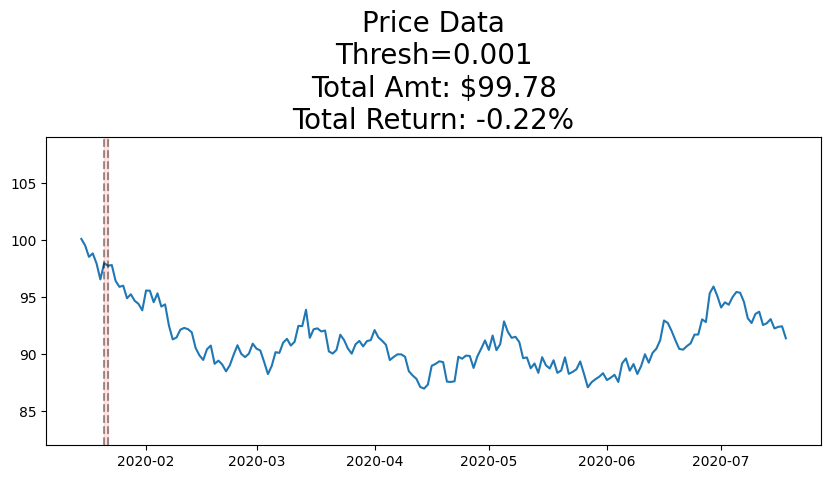

Running simulation with threshold: 0.005


  0%|          | 0/186 [00:00<?, ?it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  1%|          | 1/186 [00:00<00:29,  6.35it/s]

Date: 2020-01-15 00:00:00, Prediction: -0.005643440924136833, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  1%|          | 2/186 [00:00<00:23,  7.72it/s]

Date: 2020-01-16 00:00:00, Prediction: -0.001965692551051152, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  2%|▏         | 3/186 [00:00<00:22,  8.26it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  2%|▏         | 4/186 [00:00<00:20,  8.77it/s]

Date: 2020-01-17 00:00:00, Prediction: -0.003992932044688249, Threshold: 0.005
Date: 2020-01-18 00:00:00, Prediction: 0.0006274976156866732, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  3%|▎         | 5/186 [00:00<00:19,  9.07it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  4%|▍         | 7/186 [00:00<00:17, 10.45it/s]

Date: 2020-01-19 00:00:00, Prediction: -0.0032321344949746648, Threshold: 0.005
Date: 2020-01-20 00:00:00, Prediction: -0.005846622207351524, Threshold: 0.005
Date: 2020-01-21 00:00:00, Prediction: 0.0020207970428389108, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  5%|▍         | 9/186 [00:00<00:16, 10.67it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning:

Date: 2020-01-22 00:00:00, Prediction: -0.001151016721259151, Threshold: 0.005
Date: 2020-01-23 00:00:00, Prediction: -0.0006400722887550573, Threshold: 0.005
Date: 2020-01-24 00:00:00, Prediction: -0.003250641550334633, Threshold: 0.005
Date: 2020-01-25 00:00:00, Prediction: -0.0021716300328963527, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  7%|▋         | 13/186 [00:01<00:15, 11.45it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  8%|▊         | 15/186 [00:01<00:15, 10.74it/s]

Date: 2020-01-26 00:00:00, Prediction: -0.0011070774142201102, Threshold: 0.005
Date: 2020-01-27 00:00:00, Prediction: -0.0031515072946760683, Threshold: 0.005
Date: 2020-01-28 00:00:00, Prediction: -0.0011082032259141065, Threshold: 0.005
Date: 2020-01-29 00:00:00, Prediction: -0.0022143234317192444, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
  9%|▉         | 17/186 [00:01<00:15, 10.85it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-01-30 00:00:00, Prediction: -0.0019580370711060366, Threshold: 0.005
Date: 2020-01-31 00:00:00, Prediction: -0.002379179993998654, Threshold: 0.005
Date: 2020-02-01 00:00:00, Prediction: -0.00018515824344559348, Threshold: 0.005
Date: 2020-02-02 00:00:00, Prediction: -0.0012547878875899573, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 11%|█▏        | 21/186 [00:02<00:14, 11.34it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-03 00:00:00, Prediction: -0.00209227482869844, Threshold: 0.005
Date: 2020-02-04 00:00:00, Prediction: -0.0011144872579800615, Threshold: 0.005
Date: 2020-02-05 00:00:00, Prediction: -0.0014750612839521775, Threshold: 0.005
Date: 2020-02-06 00:00:00, Prediction: -0.0016318150215047912, Threshold: 0.005
Date: 2020-02-07 00:00:00, Prediction: -0.0011383334839591532, Threshold: 0.005
Date: 2020-02-08 00:00:00, Prediction: -0.0024427954962587574, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 15%|█▍        | 27/186 [00:02<00:13, 11.53it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-09 00:00:00, Prediction: -0.0021893157839821924, Threshold: 0.005
Date: 2020-02-10 00:00:00, Prediction: -0.0018454126189904664, Threshold: 0.005
Date: 2020-02-11 00:00:00, Prediction: -0.0017908825897522715, Threshold: 0.005
Date: 2020-02-12 00:00:00, Prediction: -0.0018347457004870937, Threshold: 0.005
Date: 2020-02-13 00:00:00, Prediction: -0.001900597495517699, Threshold: 0.005
Date: 2020-02-14 00:00:00, Prediction: -0.0024771620487173563, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 18%|█▊        | 33/186 [00:02<00:12, 12.74it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-15 00:00:00, Prediction: -0.0024706798788023294, Threshold: 0.005
Date: 2020-02-16 00:00:00, Prediction: -0.0024193710605205703, Threshold: 0.005
Date: 2020-02-17 00:00:00, Prediction: -0.0015952704960502855, Threshold: 0.005
Date: 2020-02-18 00:00:00, Prediction: -0.0016554359470510325, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 20%|█▉        | 37/186 [00:03<00:11, 13.09it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-19 00:00:00, Prediction: -0.0027152760824341276, Threshold: 0.005
Date: 2020-02-20 00:00:00, Prediction: -0.002102865517384876, Threshold: 0.005
Date: 2020-02-21 00:00:00, Prediction: -0.002192048972965227, Threshold: 0.005
Date: 2020-02-22 00:00:00, Prediction: -0.0023036034563425484, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 22%|██▏       | 41/186 [00:03<00:12, 11.40it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-02-23 00:00:00, Prediction: -0.002119204937268943, Threshold: 0.005
Date: 2020-02-24 00:00:00, Prediction: -0.0016044571840951227, Threshold: 0.005
Date: 2020-02-25 00:00:00, Prediction: -0.0010962619586739734, Threshold: 0.005
Date: 2020-02-26 00:00:00, Prediction: -0.002036546379740876, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 24%|██▍       | 45/186 [00:04<00:13, 10.64it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-02-27 00:00:00, Prediction: -0.0018721149938359504, Threshold: 0.005
Date: 2020-02-28 00:00:00, Prediction: -0.0015587870933111683, Threshold: 0.005
Date: 2020-02-29 00:00:00, Prediction: -0.0010008172472100614, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 25%|██▌       | 47/186 [00:04<00:13, 10.19it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 26%|██▋       | 49/186 [00:04<00:12, 10.88it/s]/tmp

Date: 2020-03-01 00:00:00, Prediction: -0.0017246078627543842, Threshold: 0.005
Date: 2020-03-02 00:00:00, Prediction: -0.0016140680207919688, Threshold: 0.005
Date: 2020-03-03 00:00:00, Prediction: -0.0021208946874758153, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 27%|██▋       | 51/186 [00:04<00:11, 11.90it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 28%|██▊       | 53/186 [00:04<00:10, 12.31it/s]

Date: 2020-03-04 00:00:00, Prediction: -0.0024926060268416527, Threshold: 0.005
Date: 2020-03-05 00:00:00, Prediction: -0.0013966041537559204, Threshold: 0.005
Date: 2020-03-06 00:00:00, Prediction: -0.0005245457770618287, Threshold: 0.005
Date: 2020-03-07 00:00:00, Prediction: -0.0014624238239595018, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 30%|██▉       | 55/186 [00:04<00:09, 13.57it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-08 00:00:00, Prediction: -0.0005732229665075981, Threshold: 0.005
Date: 2020-03-09 00:00:00, Prediction: -0.0008968064737961089, Threshold: 0.005
Date: 2020-03-10 00:00:00, Prediction: -0.001708119918788274, Threshold: 0.005
Date: 2020-03-11 00:00:00, Prediction: -0.0009537498359134041, Threshold: 0.005
Date: 2020-03-12 00:00:00, Prediction: 0.000290394818905929, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 32%|███▏      | 59/186 [00:05<00:10, 11.86it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-13 00:00:00, Prediction: -0.0009823227951273627, Threshold: 0.005
Date: 2020-03-14 00:00:00, Prediction: 0.0005326155262570234, Threshold: 0.005
Date: 2020-03-15 00:00:00, Prediction: -0.0013709325072214387, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 34%|███▍      | 63/186 [00:05<00:11, 10.95it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-03-16 00:00:00, Prediction: -0.0012765695123773506, Threshold: 0.005
Date: 2020-03-17 00:00:00, Prediction: -0.0010494690703878903, Threshold: 0.005
Date: 2020-03-18 00:00:00, Prediction: -0.0009827172618310375, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 35%|███▍      | 65/186 [00:05<00:12,  9.93it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 36%|███▌      | 67/186 [00:06<00:12,  9.68it/s]

Date: 2020-03-19 00:00:00, Prediction: -0.0010535737761750517, Threshold: 0.005
Date: 2020-03-20 00:00:00, Prediction: -0.0006769995615067032, Threshold: 0.005
Date: 2020-03-21 00:00:00, Prediction: -0.001228701260715784, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 37%|███▋      | 69/186 [00:06<00:11,  9.79it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-03-22 00:00:00, Prediction: -0.0013233335898527325, Threshold: 0.005
Date: 2020-03-23 00:00:00, Prediction: -0.0012573580363707763, Threshold: 0.005
Date: 2020-03-24 00:00:00, Prediction: -0.0009507663073032596, Threshold: 0.005
Date: 2020-03-25 00:00:00, Prediction: -0.0009911811973092998, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 39%|███▊      | 72/186 [00:06<00:14,  7.93it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 40%|███▉      | 74/186 [00:06<00:12,  9.02it/s]/tmp

Date: 2020-03-26 00:00:00, Prediction: -0.0011145974982011732, Threshold: 0.005
Date: 2020-03-27 00:00:00, Prediction: -0.0012867568443987612, Threshold: 0.005
Date: 2020-03-28 00:00:00, Prediction: -0.0010801103276238597, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 41%|████      | 76/186 [00:07<00:12,  9.03it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 42%|████▏     | 78/186 [00:07<00:10,  9.91it/s]/tmp

Date: 2020-03-29 00:00:00, Prediction: -0.0009820307599602749, Threshold: 0.005
Date: 2020-03-30 00:00:00, Prediction: -0.0011237917926323537, Threshold: 0.005
Date: 2020-03-31 00:00:00, Prediction: -0.001008326714884471, Threshold: 0.005
Date: 2020-04-01 00:00:00, Prediction: -0.0010351791010050362, Threshold: 0.005
Date: 2020-04-02 00:00:00, Prediction: -0.0007658735073684469, Threshold: 0.005
Date: 2020-04-03 00:00:00, Prediction: -0.0008907719299051893, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 44%|████▍     | 82/186 [00:07<00:10, 10.06it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-04-04 00:00:00, Prediction: -0.0009103309445203567, Threshold: 0.005
Date: 2020-04-05 00:00:00, Prediction: -0.0008823062637954061, Threshold: 0.005
Date: 2020-04-06 00:00:00, Prediction: -0.0011733313812044386, Threshold: 0.005
Date: 2020-04-07 00:00:00, Prediction: -0.0011194129796588273, Threshold: 0.005
Date: 2020-04-08 00:00:00, Prediction: -0.0010513597496229093, Threshold: 0.005
Date: 2020-04-09 00:00:00, Prediction: -0.00101323455361033, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 46%|████▌     | 86/186 [00:07<00:08, 11.43it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 47%|████▋     | 88/186 [00:08<00:08, 12.13it/s]/tmp

Date: 2020-04-10 00:00:00, Prediction: -0.0009180097328668284, Threshold: 0.005
Date: 2020-04-11 00:00:00, Prediction: -0.0011590448533337417, Threshold: 0.005
Date: 2020-04-12 00:00:00, Prediction: -0.0011940389888407238, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 48%|████▊     | 90/186 [00:08<00:08, 11.12it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 49%|████▉     | 92/186 [00:08<00:08, 10.79it/s]

Date: 2020-04-13 00:00:00, Prediction: -0.0012075588549228533, Threshold: 0.005
Date: 2020-04-14 00:00:00, Prediction: -0.0012869808995596992, Threshold: 0.005
Date: 2020-04-15 00:00:00, Prediction: -0.0013026261681503338, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 51%|█████     | 94/186 [00:08<00:08, 11.48it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning

Date: 2020-04-16 00:00:00, Prediction: -0.0010320178470566404, Threshold: 0.005
Date: 2020-04-17 00:00:00, Prediction: -0.0010071153056532547, Threshold: 0.005
Date: 2020-04-18 00:00:00, Prediction: -0.000964020319718735, Threshold: 0.005
Date: 2020-04-19 00:00:00, Prediction: -0.0009902261217251932, Threshold: 0.005
Date: 2020-04-20 00:00:00, Prediction: -0.0012995602457755854, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 53%|█████▎    | 98/186 [00:08<00:07, 11.52it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-04-21 00:00:00, Prediction: -0.001141885977374946, Threshold: 0.005
Date: 2020-04-22 00:00:00, Prediction: -0.0011210129187037986, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 54%|█████▍    | 100/186 [00:09<00:08, 10.59it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 55%|█████▍    | 102/186 [00:09<00:08, 10.23it/s]

Date: 2020-04-23 00:00:00, Prediction: -0.0006201274676570967, Threshold: 0.005
Date: 2020-04-24 00:00:00, Prediction: -0.0009223938939935765, Threshold: 0.005
Date: 2020-04-25 00:00:00, Prediction: -0.0008519266988740897, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 56%|█████▌    | 104/186 [00:09<00:08, 10.01it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarnin

Date: 2020-04-26 00:00:00, Prediction: -0.0008721418742128508, Threshold: 0.005
Date: 2020-04-27 00:00:00, Prediction: -0.0010422962021687495, Threshold: 0.005
Date: 2020-04-28 00:00:00, Prediction: -0.0009433295160791263, Threshold: 0.005
Date: 2020-04-29 00:00:00, Prediction: -0.0007614543479833773, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 58%|█████▊    | 108/186 [00:09<00:07, 10.36it/s]

Date: 2020-04-30 00:00:00, Prediction: -0.0006264972287964918, Threshold: 0.005
Date: 2020-05-01 00:00:00, Prediction: -0.0008226194831978128, Threshold: 0.005
Date: 2020-05-02 00:00:00, Prediction: -0.0007889302982215055, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 59%|█████▉    | 110/186 [00:10<00:08,  9.07it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-03 00:00:00, Prediction: -0.0004262078522533011, Threshold: 0.005
Date: 2020-05-04 00:00:00, Prediction: -0.0009524773254631703, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 60%|██████    | 112/186 [00:10<00:09,  8.14it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 61%|██████    | 113/186 [00:10<00:08,  8.32it/s]

Date: 2020-05-05 00:00:00, Prediction: -0.0010002890022333024, Threshold: 0.005
Date: 2020-05-06 00:00:00, Prediction: -0.0002662455960054274, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 61%|██████▏   | 114/186 [00:10<00:09,  7.89it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 62%|██████▏   | 115/186 [00:10<00:09,  7.74it/s]

Date: 2020-05-07 00:00:00, Prediction: -0.0004906869918197572, Threshold: 0.005
Date: 2020-05-08 00:00:00, Prediction: -0.0007027701871729117, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 62%|██████▏   | 116/186 [00:11<00:08,  8.05it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-09 00:00:00, Prediction: -0.0005279241301823866, Threshold: 0.005
Date: 2020-05-10 00:00:00, Prediction: -0.0003625709122327818, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 63%|██████▎   | 118/186 [00:11<00:08,  8.29it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-11 00:00:00, Prediction: -0.0008269688685278604, Threshold: 0.005
Date: 2020-05-12 00:00:00, Prediction: -0.0005448923928095095, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 65%|██████▍   | 120/186 [00:11<00:07,  8.58it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-05-13 00:00:00, Prediction: -0.0010157775185287926, Threshold: 0.005
Date: 2020-05-14 00:00:00, Prediction: -0.0005426839729812912, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 66%|██████▌   | 122/186 [00:11<00:07,  8.33it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 66%|██████▌   | 123/186 [00:11<00:07,  8.56it/s]

Date: 2020-05-15 00:00:00, Prediction: -0.0015966960121046162, Threshold: 0.005
Date: 2020-05-16 00:00:00, Prediction: -0.00038798309539565844, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 67%|██████▋   | 124/186 [00:12<00:08,  7.24it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 67%|██████▋   | 125/186 [00:12<00:08,  7.52it/s]

Date: 2020-05-17 00:00:00, Prediction: -0.0006865117502280594, Threshold: 0.005
Date: 2020-05-18 00:00:00, Prediction: -0.0012945348216645536, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 68%|██████▊   | 126/186 [00:12<00:07,  7.96it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 68%|██████▊   | 127/186 [00:12<00:07,  7.65it/s]

Date: 2020-05-19 00:00:00, Prediction: -6.451533438400292e-05, Threshold: 0.005
Date: 2020-05-20 00:00:00, Prediction: -0.001039649279151938, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 69%|██████▉   | 128/186 [00:12<00:08,  6.79it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 69%|██████▉   | 129/186 [00:12<00:08,  7.08it/s]

Date: 2020-05-21 00:00:00, Prediction: -0.0016430389832341324, Threshold: 0.005
Date: 2020-05-22 00:00:00, Prediction: 0.0004260004630847618, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 70%|██████▉   | 130/186 [00:12<00:07,  7.13it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 70%|███████   | 131/186 [00:12<00:07,  7.65it/s]

Date: 2020-05-23 00:00:00, Prediction: -0.001037709096724832, Threshold: 0.005
Date: 2020-05-24 00:00:00, Prediction: -0.0010728654886871412, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 71%|███████   | 132/186 [00:13<00:07,  7.71it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 72%|███████▏  | 133/186 [00:13<00:07,  7.41it/s]

Date: 2020-05-25 00:00:00, Prediction: -0.0014241610951726594, Threshold: 0.005
Date: 2020-05-26 00:00:00, Prediction: 0.00021127700106176434, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 73%|███████▎  | 135/186 [00:13<00:06,  8.13it/s]

Date: 2020-05-27 00:00:00, Prediction: 4.7358643539514595e-05, Threshold: 0.005
Date: 2020-05-28 00:00:00, Prediction: -0.001346910606208976, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 73%|███████▎  | 136/186 [00:13<00:06,  8.03it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 74%|███████▎  | 137/186 [00:13<00:06,  7.92it/s]

Date: 2020-05-29 00:00:00, Prediction: -0.0011284699132363563, Threshold: 0.005
Date: 2020-05-30 00:00:00, Prediction: -0.0010644458394858435, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 74%|███████▍  | 138/186 [00:13<00:05,  8.16it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 75%|███████▍  | 139/186 [00:13<00:05,  8.43it/s]

Date: 2020-05-31 00:00:00, Prediction: -0.001104097839766902, Threshold: 0.005
Date: 2020-06-01 00:00:00, Prediction: -0.00034442168299476494, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 75%|███████▌  | 140/186 [00:14<00:05,  8.13it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 76%|███████▌  | 141/186 [00:14<00:06,  7.44it/s]

Date: 2020-06-02 00:00:00, Prediction: -0.001046222358216555, Threshold: 0.005
Date: 2020-06-03 00:00:00, Prediction: -0.001065128259561467, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 76%|███████▋  | 142/186 [00:14<00:07,  6.25it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 77%|███████▋  | 144/186 [00:14<00:05,  8.07it/s]

Date: 2020-06-04 00:00:00, Prediction: -0.00030117073342734654, Threshold: 0.005
Date: 2020-06-05 00:00:00, Prediction: -0.0024299828907193674, Threshold: 0.005
Date: 2020-06-06 00:00:00, Prediction: -0.001088007313677414, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 78%|███████▊  | 146/186 [00:14<00:04,  8.52it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 79%|███████▉  | 147/186 [00:14<00:04,  8.69it/s]

Date: 2020-06-07 00:00:00, Prediction: 0.00021380412925859022, Threshold: 0.005
Date: 2020-06-08 00:00:00, Prediction: -0.00132608829935224, Threshold: 0.005
Date: 2020-06-09 00:00:00, Prediction: 0.00010577251915591733, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 80%|███████▉  | 148/186 [00:15<00:04,  8.81it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 80%|████████  | 149/186 [00:15<00:04,  8.79it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-10 00:00:00, Prediction: -0.0015265912362484818, Threshold: 0.005
Date: 2020-06-11 00:00:00, Prediction: -0.0017117777267645464, Threshold: 0.005
Date: 2020-06-12 00:00:00, Prediction: 7.081454171321518e-05, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 81%|████████  | 151/186 [00:15<00:03,  9.36it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 82%|████████▏ | 152/186 [00:15<00:03,  9.32it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 8

Date: 2020-06-13 00:00:00, Prediction: -0.0016266675764651517, Threshold: 0.005
Date: 2020-06-14 00:00:00, Prediction: -0.001019240802372423, Threshold: 0.005
Date: 2020-06-15 00:00:00, Prediction: -0.0013321951295052268, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 83%|████████▎ | 154/186 [00:15<00:03,  9.19it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 83%|████████▎ | 155/186 [00:15<00:03,  9.12it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-16 00:00:00, Prediction: -0.0019764202472690776, Threshold: 0.005
Date: 2020-06-17 00:00:00, Prediction: -0.00023884794457495966, Threshold: 0.005
Date: 2020-06-18 00:00:00, Prediction: 0.00012706633568463862, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 84%|████████▍ | 157/186 [00:16<00:03,  9.25it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 85%|████████▍ | 158/186 [00:16<00:03,  8.40it/s]

Date: 2020-06-19 00:00:00, Prediction: 0.0001481469315852195, Threshold: 0.005
Date: 2020-06-20 00:00:00, Prediction: 8.079535627675055e-06, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 85%|████████▌ | 159/186 [00:16<00:03,  7.97it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 86%|████████▌ | 160/186 [00:16<00:03,  7.87it/s]

Date: 2020-06-21 00:00:00, Prediction: -0.0005280564547368549, Threshold: 0.005
Date: 2020-06-22 00:00:00, Prediction: -0.0008046179549621819, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 87%|████████▋ | 161/186 [00:16<00:03,  8.33it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 87%|████████▋ | 162/186 [00:16<00:02,  8.08it/s]

Date: 2020-06-23 00:00:00, Prediction: -0.0007353562613223813, Threshold: 0.005
Date: 2020-06-24 00:00:00, Prediction: -0.0010559698941601985, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 88%|████████▊ | 163/186 [00:16<00:02,  8.18it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 88%|████████▊ | 164/186 [00:16<00:02,  8.17it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-06-25 00:00:00, Prediction: -0.0004893325024986054, Threshold: 0.005
Date: 2020-06-26 00:00:00, Prediction: -0.0013762643603723649, Threshold: 0.005
Date: 2020-06-27 00:00:00, Prediction: -0.0002215653402980336, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 89%|████████▉ | 166/186 [00:17<00:02,  8.73it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 90%|████████▉ | 167/186 [00:17<00:02,  7.65it/s]

Date: 2020-06-28 00:00:00, Prediction: -0.0022303934151702703, Threshold: 0.005
Date: 2020-06-29 00:00:00, Prediction: -0.0005668302556579659, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 90%|█████████ | 168/186 [00:17<00:02,  8.06it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 91%|█████████ | 169/186 [00:17<00:02,  8.37it/s]

Date: 2020-06-30 00:00:00, Prediction: 0.00028013342484439226, Threshold: 0.005
Date: 2020-07-01 00:00:00, Prediction: 0.0002928463148712582, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 91%|█████████▏| 170/186 [00:17<00:01,  8.02it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 92%|█████████▏| 171/186 [00:17<00:01,  7.72it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 9

Date: 2020-07-02 00:00:00, Prediction: -0.0005651809747005295, Threshold: 0.005
Date: 2020-07-03 00:00:00, Prediction: -0.0001584565386474197, Threshold: 0.005
Date: 2020-07-04 00:00:00, Prediction: -0.0006840076995495619, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 93%|█████████▎| 173/186 [00:18<00:01,  8.53it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-07-05 00:00:00, Prediction: -0.0004954455186272982, Threshold: 0.005


 94%|█████████▎| 174/186 [00:18<00:01,  6.93it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 94%|█████████▍| 175/186 [00:18<00:01,  7.30it/s]

Date: 2020-07-06 00:00:00, Prediction: -0.000181526902488753, Threshold: 0.005
Date: 2020-07-07 00:00:00, Prediction: 0.0002196111320281737, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 95%|█████████▍| 176/186 [00:18<00:01,  7.67it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 95%|█████████▌| 177/186 [00:18<00:01,  6.88it/s]

Date: 2020-07-08 00:00:00, Prediction: 0.00041002459875762285, Threshold: 0.005
Date: 2020-07-09 00:00:00, Prediction: -0.00016649525635641126, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 96%|█████████▌| 178/186 [00:18<00:01,  7.40it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 96%|█████████▌| 179/186 [00:18<00:00,  7.86it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]


Date: 2020-07-10 00:00:00, Prediction: -0.0007346350830047412, Threshold: 0.005
Date: 2020-07-11 00:00:00, Prediction: -0.000409296898987479, Threshold: 0.005
Date: 2020-07-12 00:00:00, Prediction: 0.00022499073081747517, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 97%|█████████▋| 181/186 [00:19<00:00,  9.12it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 98%|█████████▊| 182/186 [00:19<00:00,  9.21it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 9

Date: 2020-07-13 00:00:00, Prediction: -0.0004502656006758445, Threshold: 0.005
Date: 2020-07-14 00:00:00, Prediction: -0.0005328003002970645, Threshold: 0.005
Date: 2020-07-15 00:00:00, Prediction: 6.068394842526808e-05, Threshold: 0.005


/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
 99%|█████████▉| 185/186 [00:19<00:00, 10.21it/s]/tmp/ipykernel_76117/3160666080.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model.forecast()[0]
100%|██████████| 186/186 [00:19<00:00,  9.52it/s]


Date: 2020-07-16 00:00:00, Prediction: -0.0004583364380749191, Threshold: 0.005
Date: 2020-07-17 00:00:00, Prediction: -0.0004058317712355589, Threshold: 0.005
Date: 2020-07-18 00:00:00, Prediction: 0.00016277956830599113, Threshold: 0.005
Total Amount: $100


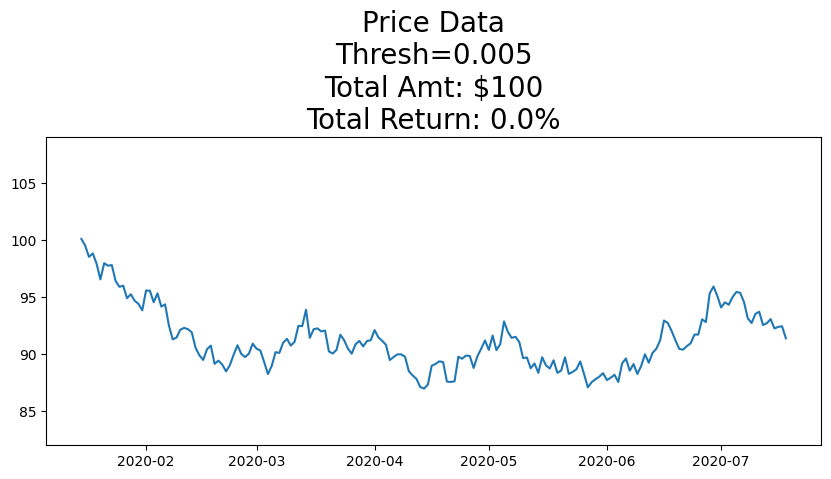

In [54]:
from statsmodels.tsa.arima.model import ARIMA  # Updated import

def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    # Go through dates
    for date, r in tqdm(returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        # If currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt *= (1 + ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s' % sell_price)
                print('Predicted Return: %s' % round(pred, 4))
                print('Actual Return: %s' % round(ret, 4))
                print('=======================================')
            continue

        # Get data till just before the current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                # Fit model
                model = ARIMA(curr_data, order=order).fit()

                # Get forecast
                pred = model.forecast()[0]
            except Exception as e:
                if verbose:
                    print(f"ARIMA model fitting failed on {date} with error: {e}")
                pred = thresh - 1

        # Debug statements to check predictions and threshold comparisons
        if verbose:
            print(f"Date: {date}, Prediction: {pred}, Threshold: {thresh}")

        # If you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
           ((type(order) == float and np.random.random() < order) or 
            (type(order) == tuple and pred > thresh) or 
            (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s' % buy_price)
                
    if verbose:
        print('Total Amount: $%s' % round(amt, 2))
        
    # Graph
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min() * .95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * .5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx - 1][1], color=color, alpha=0.1)

        tot_return = round(100 * (amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s" % (thresh, round(amt, 2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Generate synthetic data for testing
np.random.seed(42)
dates = pd.date_range(start='2020-01-01', periods=200, freq='D')
returns = pd.Series(np.random.randn(200) / 100, index=dates)
prices = (100 * (1 + returns).cumprod()).round(2)

# Test with various thresholds
for thresh in [0, 0.001, 0.005]:
    print(f"Running simulation with threshold: {thresh}")
    run_simulation(returns, prices, 100, (1, 0, 0), thresh, verbose=True)
